#  MODIS Water Clustering Analysis

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

In [2]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
GPU = True
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5
num_datapoints = 10000000

In [22]:
##############################
#VERSION 4.2.0
# TILE_IN = 'Golden'#v4.2.1
# DATA_VERSION='v4.2.1'
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
##############################

##############################
#VERSION 2.0.0
TILE_IN = 'GLOBAL'#v2.0.1
DATA_VERSION='v2.0.1'
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
##############################

training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip


## Functions

In [3]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]

    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

In [4]:

def plotting_clusters(X_w,kme_w,kmeans_output,n_cluster):
    fig = plt.figure(figsize = (25, 10))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')

    ax1 = plt.subplot(131)
    ax1.set_title(f'Land and Water Datapoints')
    ax1.scatter(X_w.values[:,0], X_w.values[:,1],label='Water')
    ax1.scatter(X_l.values[:,0], X_l.values[:,1],label='Land')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)
    ax1.set_xlabel(X_w.columns[0])
    ax1.set_ylabel(X_w.columns[1])
    ax1.legend(loc='lower right',fontsize="20")

    ax2 = plt.subplot(132)
    ax2.set_title(f'Water Datapoints Clustered: {len(X_water)} Examples')
    ax2.scatter(X_w.values[:,0], X_w.values[:,1],c=kmeans_output_w,cmap='tab10')
    ax2.scatter(kme_w.cluster_centers_[:,0],kme_w.cluster_centers_[:,1],
            label='Center Point',c='k',s=150)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='minor', labelsize=10)
    ax2.set_xlabel(X_w.columns[0])
    ax2.set_ylabel(X_w.columns[1])
    ax2.legend(loc='lower right',fontsize="20")

    ax3 = plt.subplot(133)
 
    ax3.set_title(f'Land Datapoints Clustered: {len(X_land)} Examples')
    ax3.scatter(X_l.values[:,0], X_l.values[:,1],c=kmeans_output_l,cmap='tab10')
    ax3.scatter(kme_l.cluster_centers_[:,0],kme_l.cluster_centers_[:,1],label='Center Point',c='k',s=150)
    ax3.tick_params(axis='both', which='major', labelsize=10)
    ax3.tick_params(axis='both', which='minor', labelsize=10)
    ax3.set_xlabel(X_l.columns[0])
    ax3.set_ylabel(X_l.columns[1])
    ax3.legend(loc='lower right',fontsize="20")

    plt.show()

In [34]:

def plotting_3d(X_w,X_l,n_cluster):
    fig = plt.figure(figsize = (15, 7))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')
    ax = plt.subplot(111,projection='3d')
    ax.set_title(f'Land and Water Datapoints')
    ax.scatter(X_w.values[:,0], X_w.values[:,1], X_w.values[:,2],label='Water')
    ax.scatter(X_l.values[:,0], X_l.values[:,1],  X_l.values[:,2], label='Land')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(X_w.columns[0])
    ax.set_ylabel(X_w.columns[1])
    ax.set_zlabel(X_w.columns[2])
    ax.legend(fontsize="10")
    plt.show()
    
    
def plotting_clusters_3d(X,kme,kmeans_output,n_cluster,axtitle):
    fig = plt.figure(figsize = (15, 7))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')
    ax = plt.subplot(111,projection='3d')
    ax.set_title(f'{axtitle}')#Land Datapoints Clustered: {len(X_land)} Examples')
    ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2], c=kmeans_output,cmap='tab10')
    # ax.scatter(kme.cluster_centers_[:,0],kme.cluster_centers_[:,1],kme.cluster_centers_[:,2],
                    # label='Center Point',c='k',s=150)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_zlabel(X.columns[2])
    ax.legend(fontsize="10")
    plt.show()

In [23]:
colsToDrop = [
            #'sur_refl_b01_1',
            # 'sur_refl_b02_1',
             'sur_refl_b03_1',
             'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
            # 'sur_refl_b07_1',
             'ndvi',
             'ndwi1','ndwi2'
            ]

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

## Start off with just surface reflectance bands 1,2

### Input data

In [24]:
colsToDrop

['sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'sur_refl_b06_1',
 'ndvi',
 'ndwi1',
 'ndwi2']

In [25]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                # imbalance=True,
                                # frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

subset data shape: (4375821, 3), (4375821,)


#### separate the land and water points

In [26]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind = np.where(y>0.5)[0]
y_land_ind = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water = X.iloc[y_water_ind,:]
y_water = y.iloc[y_water_ind]

X_land = X.iloc[y_land_ind,:]
y_land = y.iloc[y_land_ind]

In [27]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b07_1


### kmeans land and water together

Text(0, 0.5, 'sur_refl_b02_1')

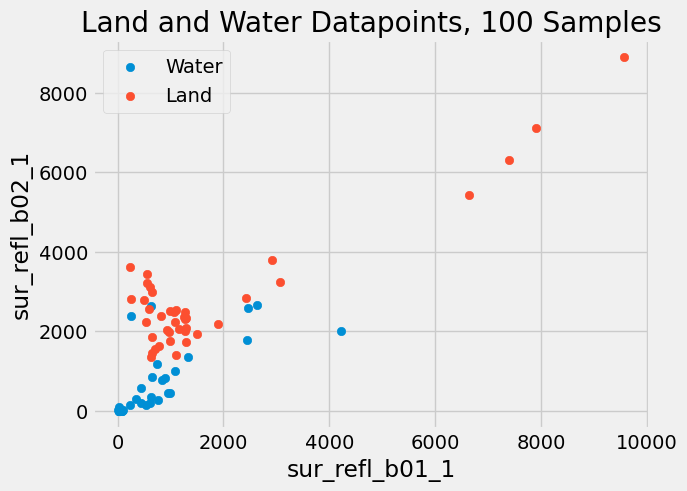

In [67]:
# plt.scatter(X_water.values[:,0], X_water.values[:,1],label='Water')
# plt.scatter(X_land.values[:,0], X_land.values[:,1],label='Land')
# plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_water.columns[0])
# plt.ylabel(X_water.columns[1])

In [12]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [14]:
%%time
kme_water =  KMeans(n_clusters=5, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 71.9 ms, sys: 11.3 ms, total: 83.1 ms
Wall time: 8.43 ms


In [15]:
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)

57
[2 4 1 0 2 0 2 1 0 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 0 2
 2 0 2 3 2 2 0 4 1 1 2 2 2 2 4 1 2 2 2 2]
[[ 994.5        1297.125     ]
 [4068.4        3552.2       ]
 [ 154.18421053   90.42105263]
 [5887.         5580.        ]
 [2662.2        2480.        ]]


Text(0, 0.5, 'sur_refl_b02_1')

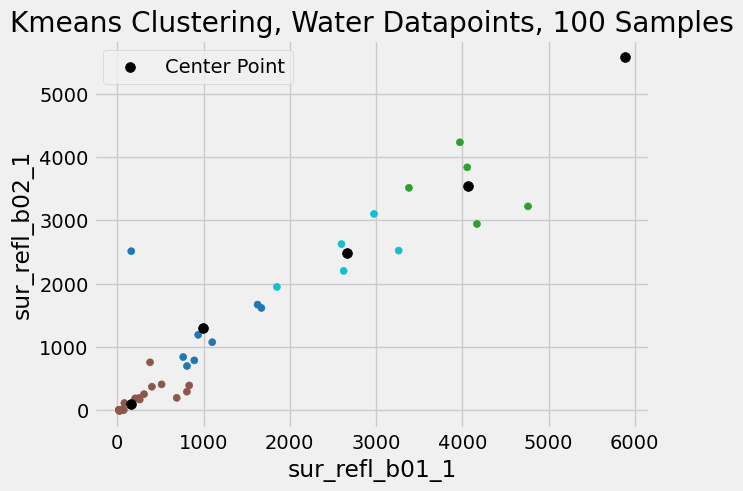

In [48]:
plt.scatter(X_water.values[:,0], X_water.values[:,1],
            c=kmeans_output_water,cmap='tab10',s=25)
plt.scatter(kme_water.cluster_centers_[:,0],kme_water.cluster_centers_[:,1],
            label='Center Point',c='k',s=50)
plt.title(f'Kmeans Clustering, Water Datapoints, {num_datapoints} Samples')
plt.legend()
plt.xlabel(X_water.columns[0])
plt.ylabel(X_water.columns[1])

Text(0, 0.5, 'sur_refl_b02_1')

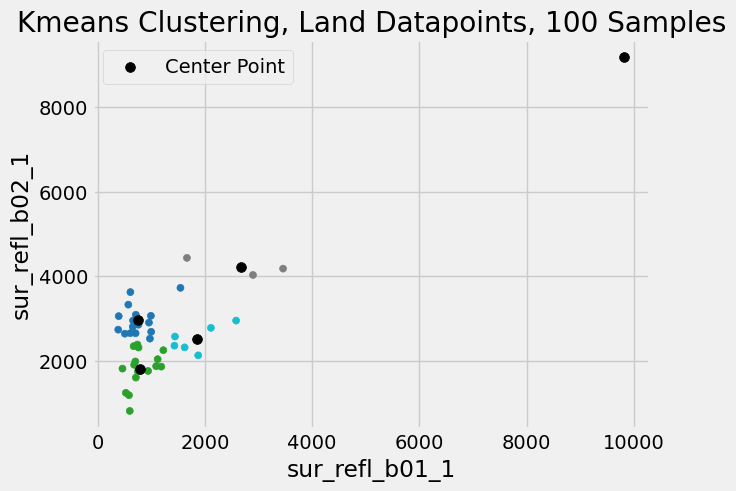

In [42]:
# plt.scatter(X_land.values[:,0], X_land.values[:,1],
#             c=kmeans_output_land,cmap='tab10',s=25)
# plt.scatter(kme_land.cluster_centers_[:,0],kme_land.cluster_centers_[:,1],
#             label='Center Point',c='k',s=50)
# plt.title(f'Kmeans Clustering, Land Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_land.columns[0])
# plt.ylabel(X_land.columns[1])

### kmeans land versus water analysis

In [74]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

#### varying cluster number

##### 5

In [75]:
CLUSTER_NUM=5

In [76]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 27.4 s, sys: 3.78 s, total: 31.1 s
Wall time: 3.83 s


In [77]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 31 s, sys: 4.04 s, total: 35.1 s
Wall time: 3.32 s


In [78]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)

water
1976791
[0 3 4 ... 3 0 0]
[[  26.58489648    7.05594394]
 [1157.89053436 1059.89802543]
 [5530.08697479 5540.42478992]
 [ 469.14441005  319.86639908]
 [1539.71196724 2783.27362354]]

land
2399030
[4 2 3 ... 3 3 2]
[[2092.74327357 3030.04407696]
 [ 463.7404102   947.29255108]
 [ 452.96388296 4099.01703769]
 [ 500.68183992 2954.52499397]
 [ 670.99987918 2083.88175109]]


##### 5 plot

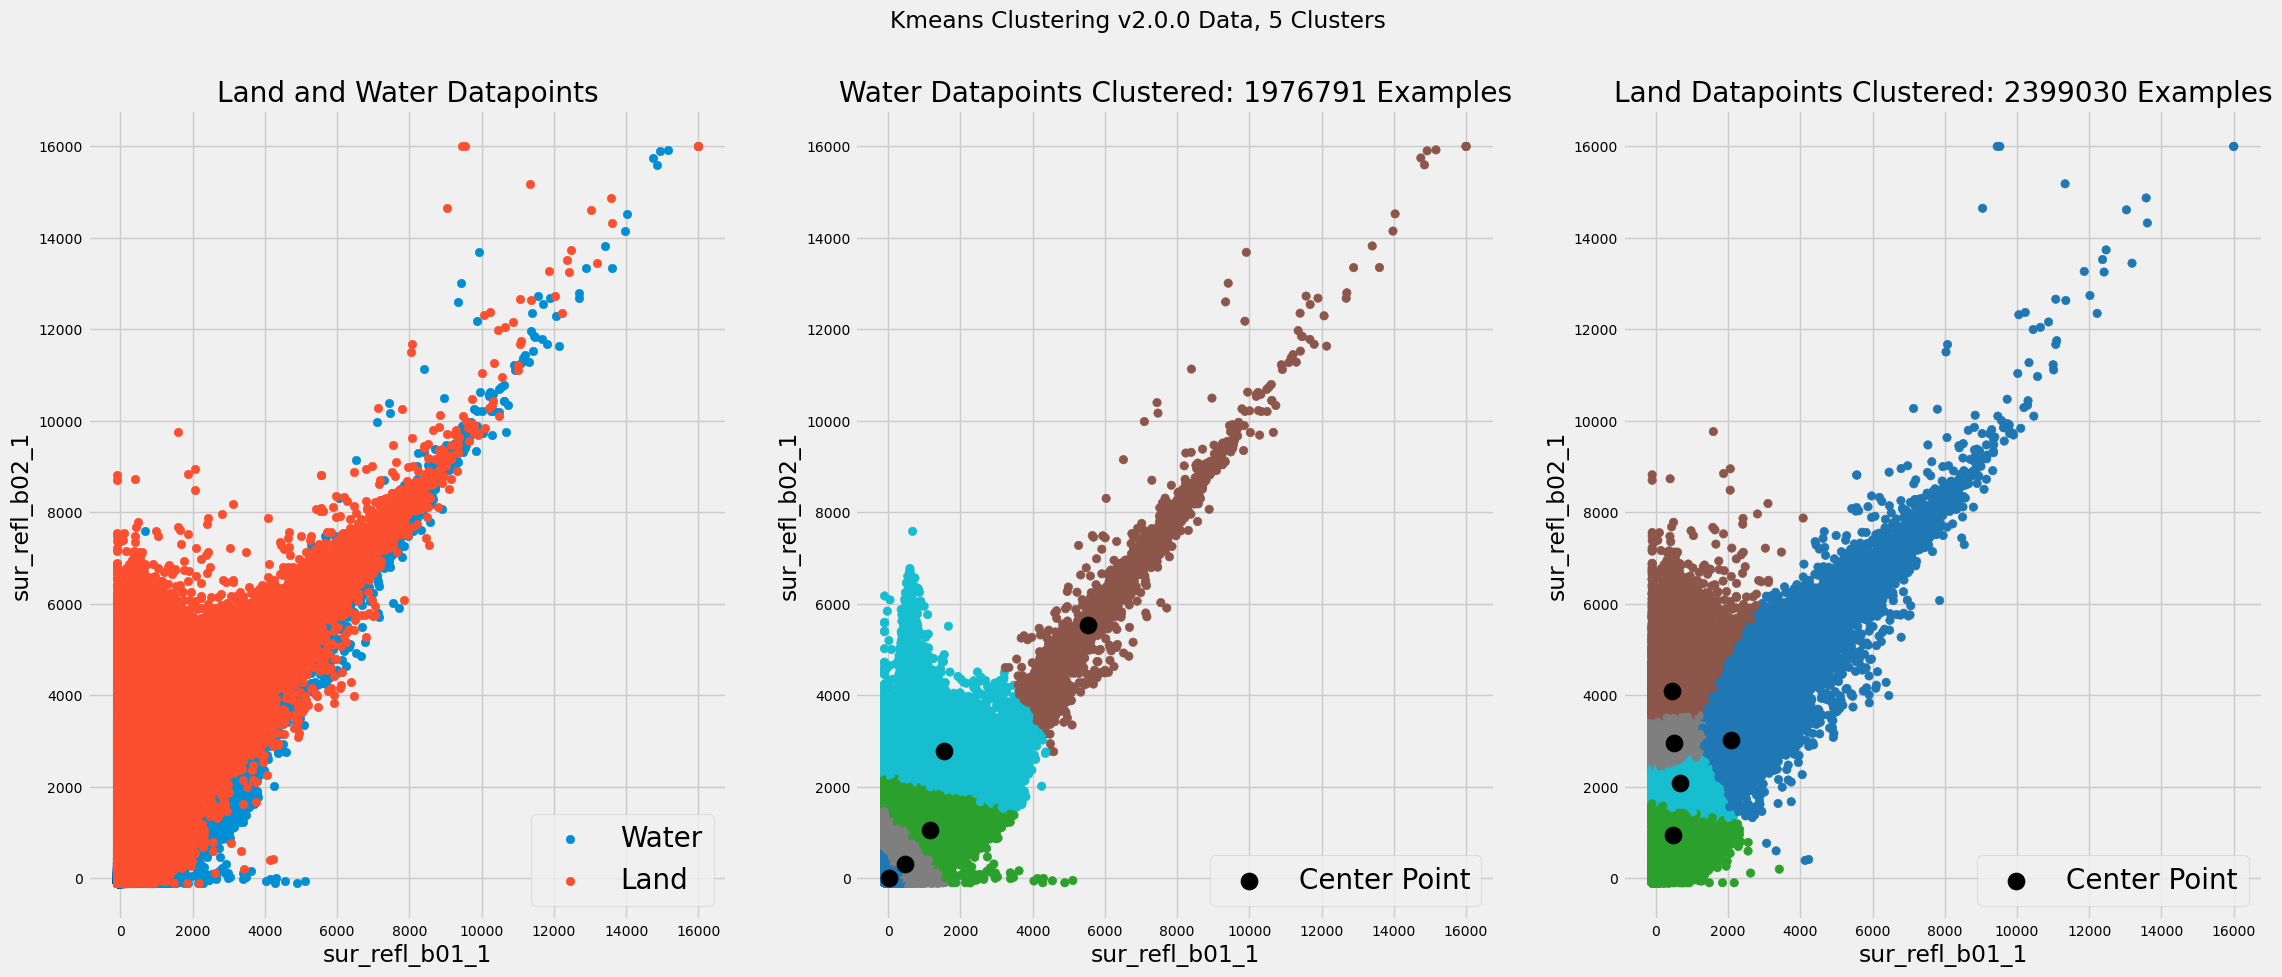

In [80]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 10

In [81]:
CLUSTER_NUM=10

In [82]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 34.7 s, sys: 5.04 s, total: 39.7 s
Wall time: 3.32 s


In [83]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 49.2 s, sys: 7.14 s, total: 56.4 s
Wall time: 4.75 s


In [92]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1976791
[0 8 4 ... 9 8 0]
[[ 9.06917436e+00 -2.90345275e+00]
 [ 1.31316200e+03  8.36037392e+02]
 [ 5.28402039e+03  5.29786996e+03]
 [ 4.53058293e+02  5.08654662e+02]
 [ 9.78517735e+02  2.56923103e+03]
 [ 2.52149482e+03  2.32724609e+03]
 [ 3.92526372e+02  2.34346836e+02]
 [ 6.75658023e+02  1.01298843e+03]
 [ 1.86117573e+02  1.04515873e+02]
 [ 8.18588463e+02  3.64581828e+02]
 [ 1.06996632e+04  1.10223579e+04]
 [ 1.44658985e+03  1.65198661e+03]
 [ 3.78707454e+03  3.75959058e+03]
 [ 7.26358872e+03  7.30818562e+03]
 [ 7.96548698e+02  3.90795781e+03]]

land
2399030
[3 5 9 ... 9 2 5]
[[1050.3084974  3409.64082789]
 [ 459.40045593 1695.6382838 ]
 [ 388.79884329 3282.85672196]
 [ 481.21584859 2222.08954228]
 [ 438.66240769 4753.25658383]
 [ 412.49717333 3939.27906183]
 [2194.05817652 2999.30577088]
 [1565.52050821 2431.69559693]
 [5910.66375546 6661.20524017]
 [ 781.55685864 2712.8405921 ]
 [ 584.10723757 1083.21993664]
 [2907.76756033 3911.9995166 ]
 [ 252.76579338  386.20020348]
 [ 303.

15

##### 10 plot

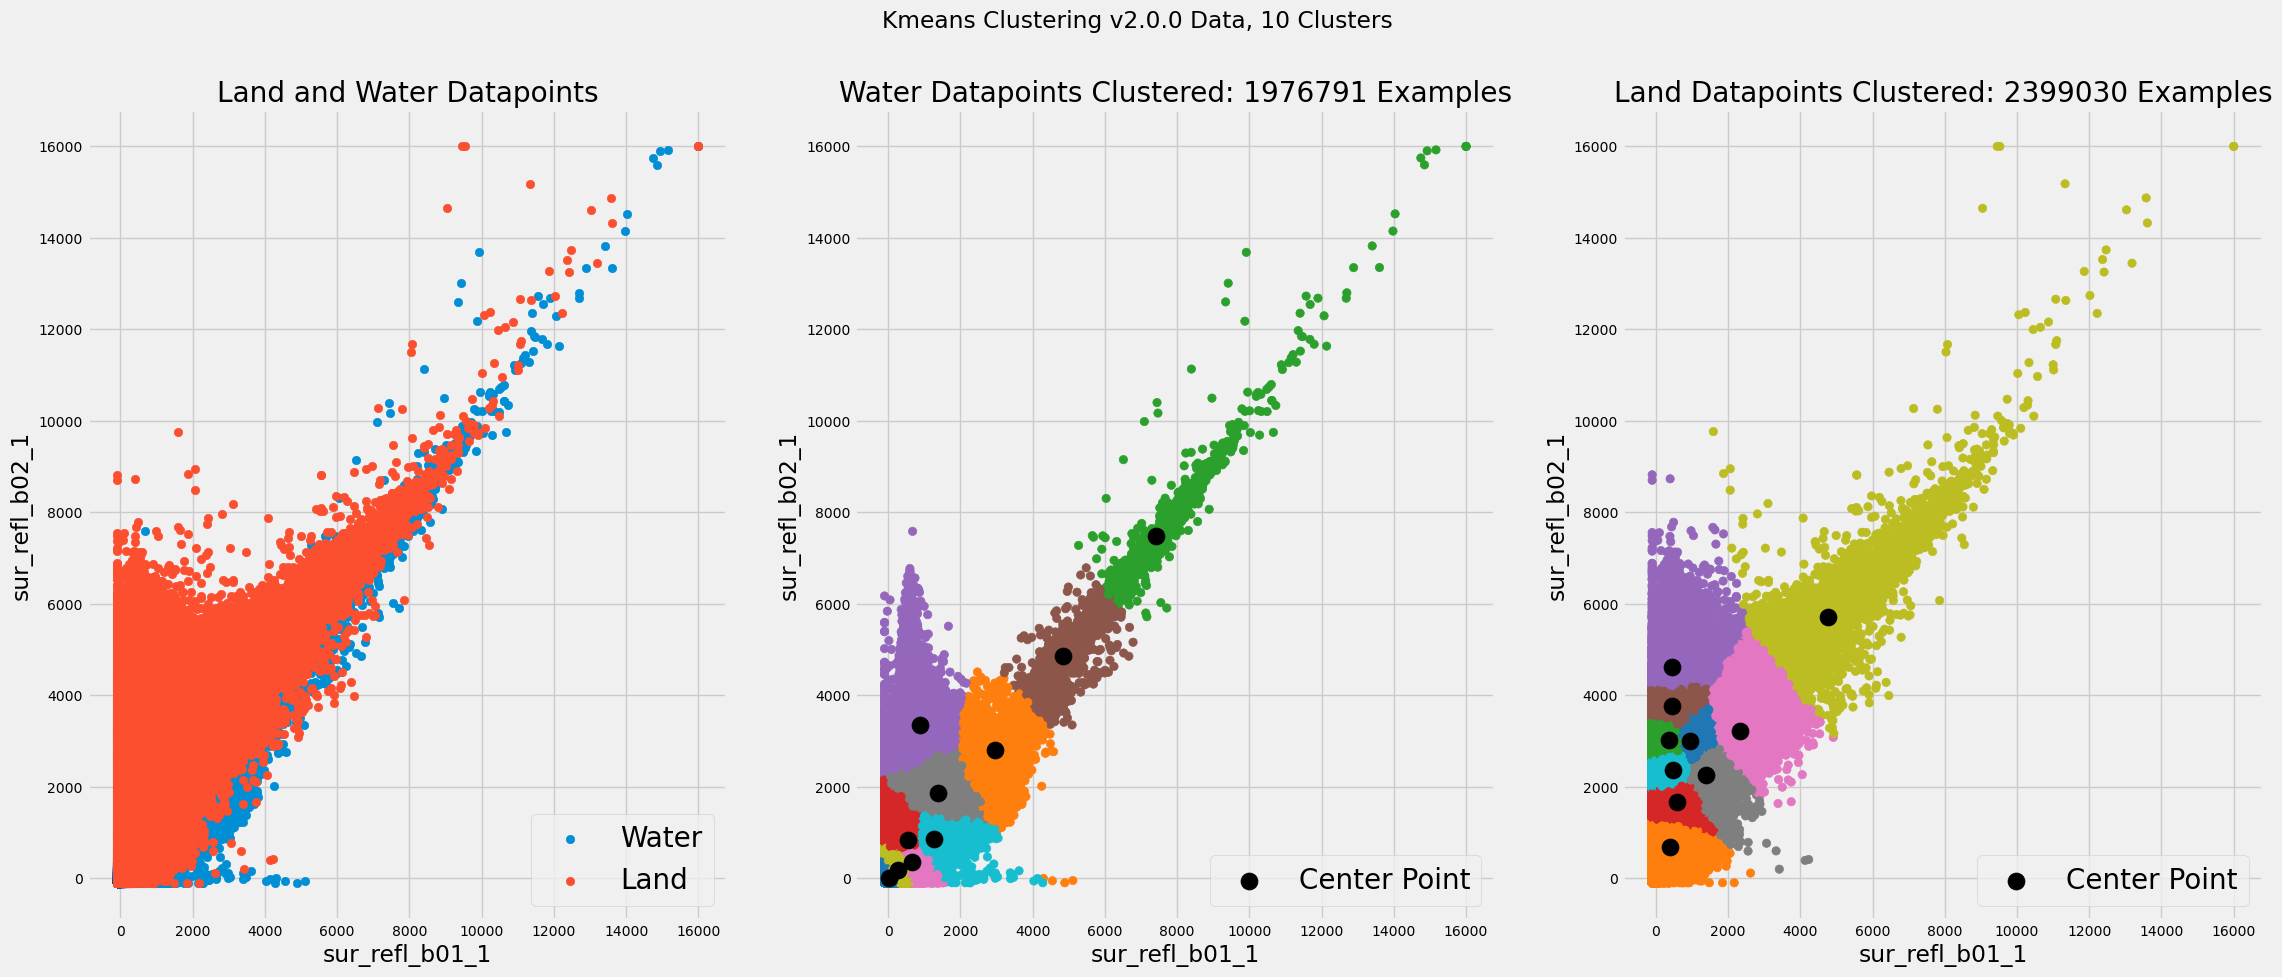

In [85]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 15

In [86]:
CLUSTER_NUM=15

In [87]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 55.4 s, sys: 6.05 s, total: 1min 1s
Wall time: 1.83 s


In [88]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 1min 18s, sys: 7.81 s, total: 1min 25s
Wall time: 2.4 s


In [90]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1976791
[0 8 4 ... 9 8 0]
[[ 9.06917436e+00 -2.90345275e+00]
 [ 1.31316200e+03  8.36037392e+02]
 [ 5.28402039e+03  5.29786996e+03]
 [ 4.53058293e+02  5.08654662e+02]
 [ 9.78517735e+02  2.56923103e+03]
 [ 2.52149482e+03  2.32724609e+03]
 [ 3.92526372e+02  2.34346836e+02]
 [ 6.75658023e+02  1.01298843e+03]
 [ 1.86117573e+02  1.04515873e+02]
 [ 8.18588463e+02  3.64581828e+02]
 [ 1.06996632e+04  1.10223579e+04]
 [ 1.44658985e+03  1.65198661e+03]
 [ 3.78707454e+03  3.75959058e+03]
 [ 7.26358872e+03  7.30818562e+03]
 [ 7.96548698e+02  3.90795781e+03]]

land
2399030
[3 5 9 ... 9 2 5]
[[1050.3084974  3409.64082789]
 [ 459.40045593 1695.6382838 ]
 [ 388.79884329 3282.85672196]
 [ 481.21584859 2222.08954228]
 [ 438.66240769 4753.25658383]
 [ 412.49717333 3939.27906183]
 [2194.05817652 2999.30577088]
 [1565.52050821 2431.69559693]
 [5910.66375546 6661.20524017]
 [ 781.55685864 2712.8405921 ]
 [ 584.10723757 1083.21993664]
 [2907.76756033 3911.9995166 ]
 [ 252.76579338  386.20020348]
 [ 303.

15

##### 15 plot

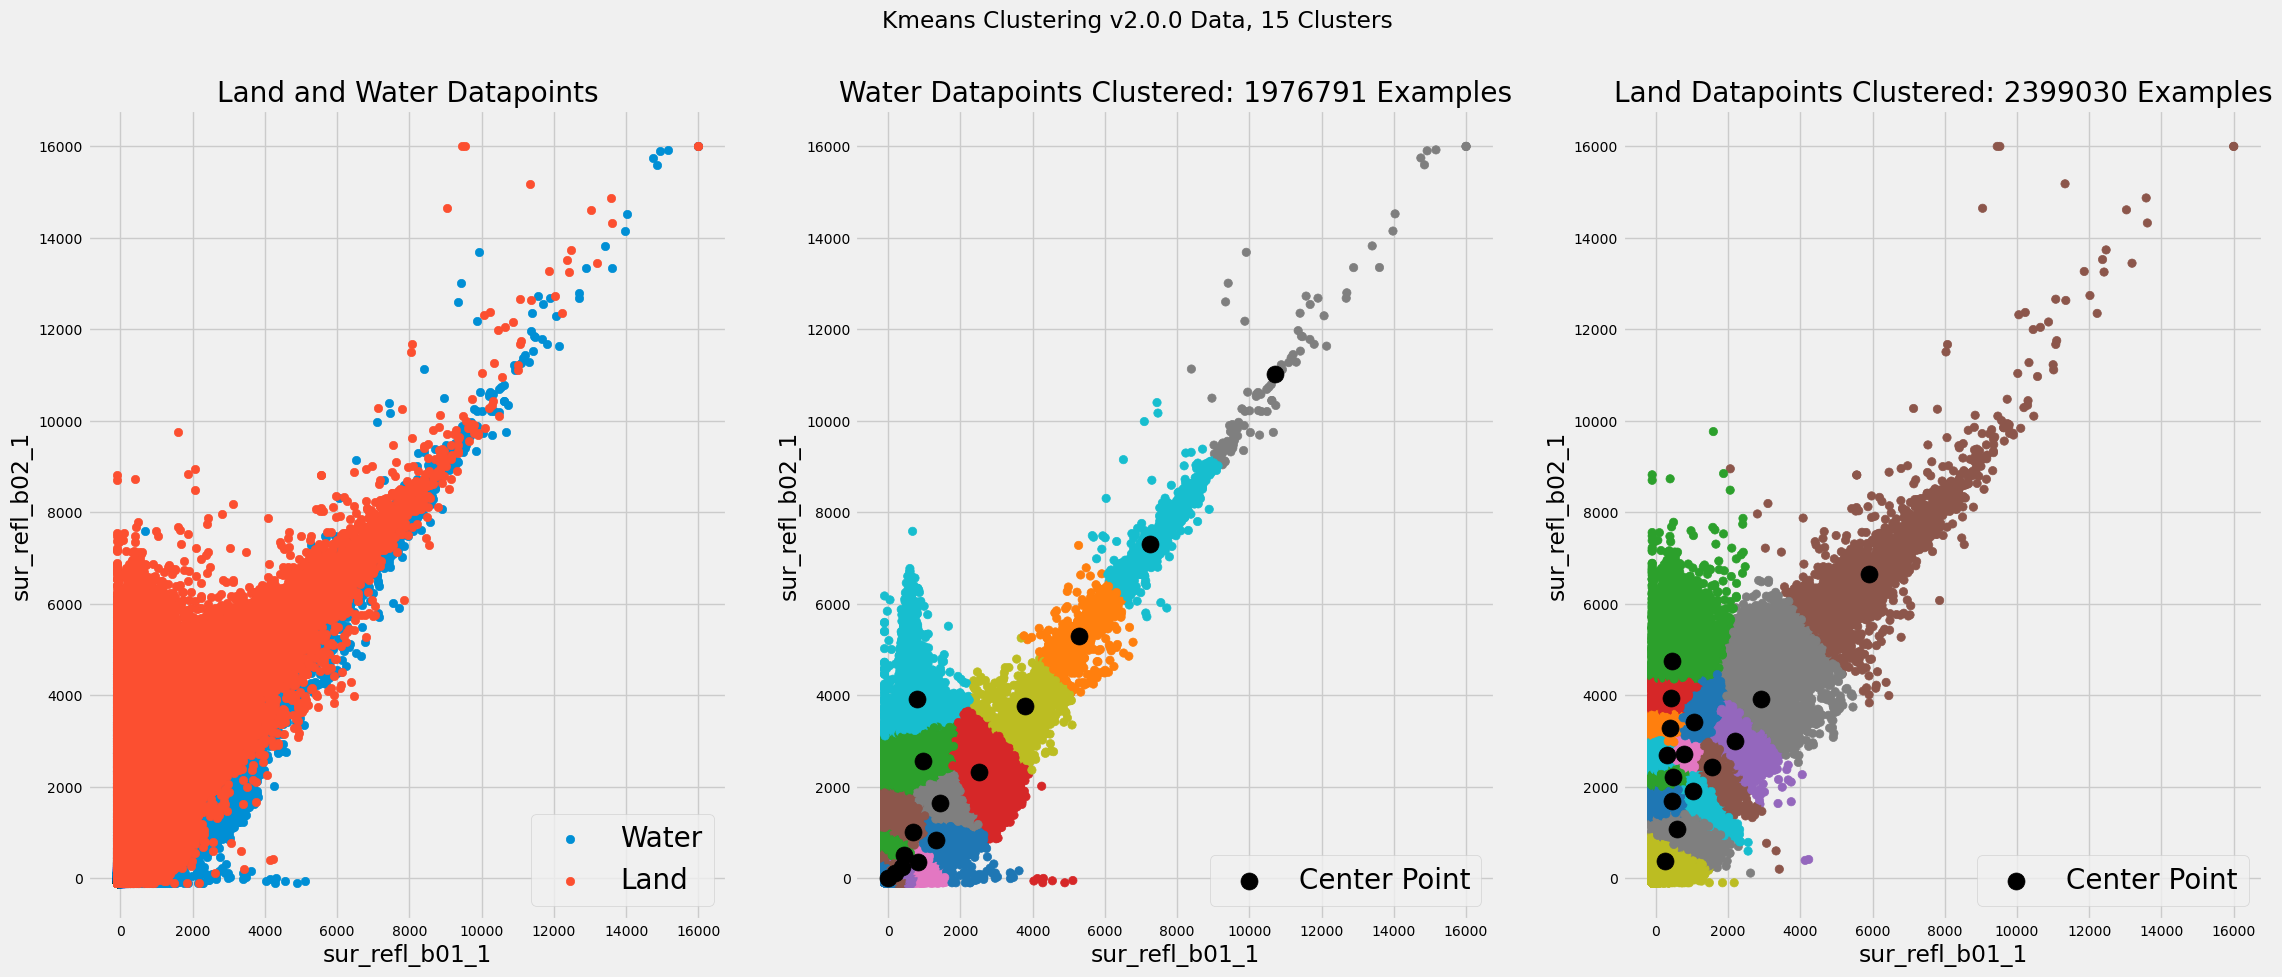

In [91]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 20

In [94]:
CLUSTER_NUM=20

In [95]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 1min 14s, sys: 8.41 s, total: 1min 22s
Wall time: 2.3 s


In [96]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 1min, sys: 6.76 s, total: 1min 6s
Wall time: 1.85 s


In [97]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1976791
[19  8  4 ...  6 16 19]
[[-4.49822181e+01 -1.29587663e+01]
 [ 1.31497928e+03  1.09047783e+03]
 [ 6.13085052e+03  6.16001119e+03]
 [ 4.13943888e+02  4.53599552e+02]
 [ 9.81005320e+02  2.83940077e+03]
 [ 3.68067598e+03  3.64274760e+03]
 [ 7.08481567e+02  3.06244390e+02]
 [ 7.07765736e+02  1.71770279e+03]
 [ 3.56118281e+02  2.14289579e+02]
 [ 1.08349266e+03  5.37210783e+02]
 [ 1.15290508e+04  1.19966102e+04]
 [ 2.58718529e+03  2.55376294e+03]
 [ 4.83375357e+03  4.83453728e+03]
 [ 7.84780150e+03  7.89909023e+03]
 [ 7.47913231e+02  4.11881704e+03]
 [ 2.21897336e+03  1.30042256e+03]
 [ 1.83772318e+02  1.02679973e+02]
 [ 1.52100982e+03  1.87294339e+03]
 [ 6.34380340e+02  8.35956525e+02]
 [ 3.21449140e+01  1.47405702e+00]]

land
2399030
[ 3 19  9 ...  9  2 19]
[[1224.93440661 2837.34543411]
 [ 429.19496808 1538.31209336]
 [ 293.13877236 3075.13172353]
 [ 436.23445223 2033.0144591 ]
 [ 423.70330418 4959.2595715 ]
 [1213.85800979 3815.18287682]
 [2002.55229059 2761.12043694]
 [1475

20

##### 20 plot

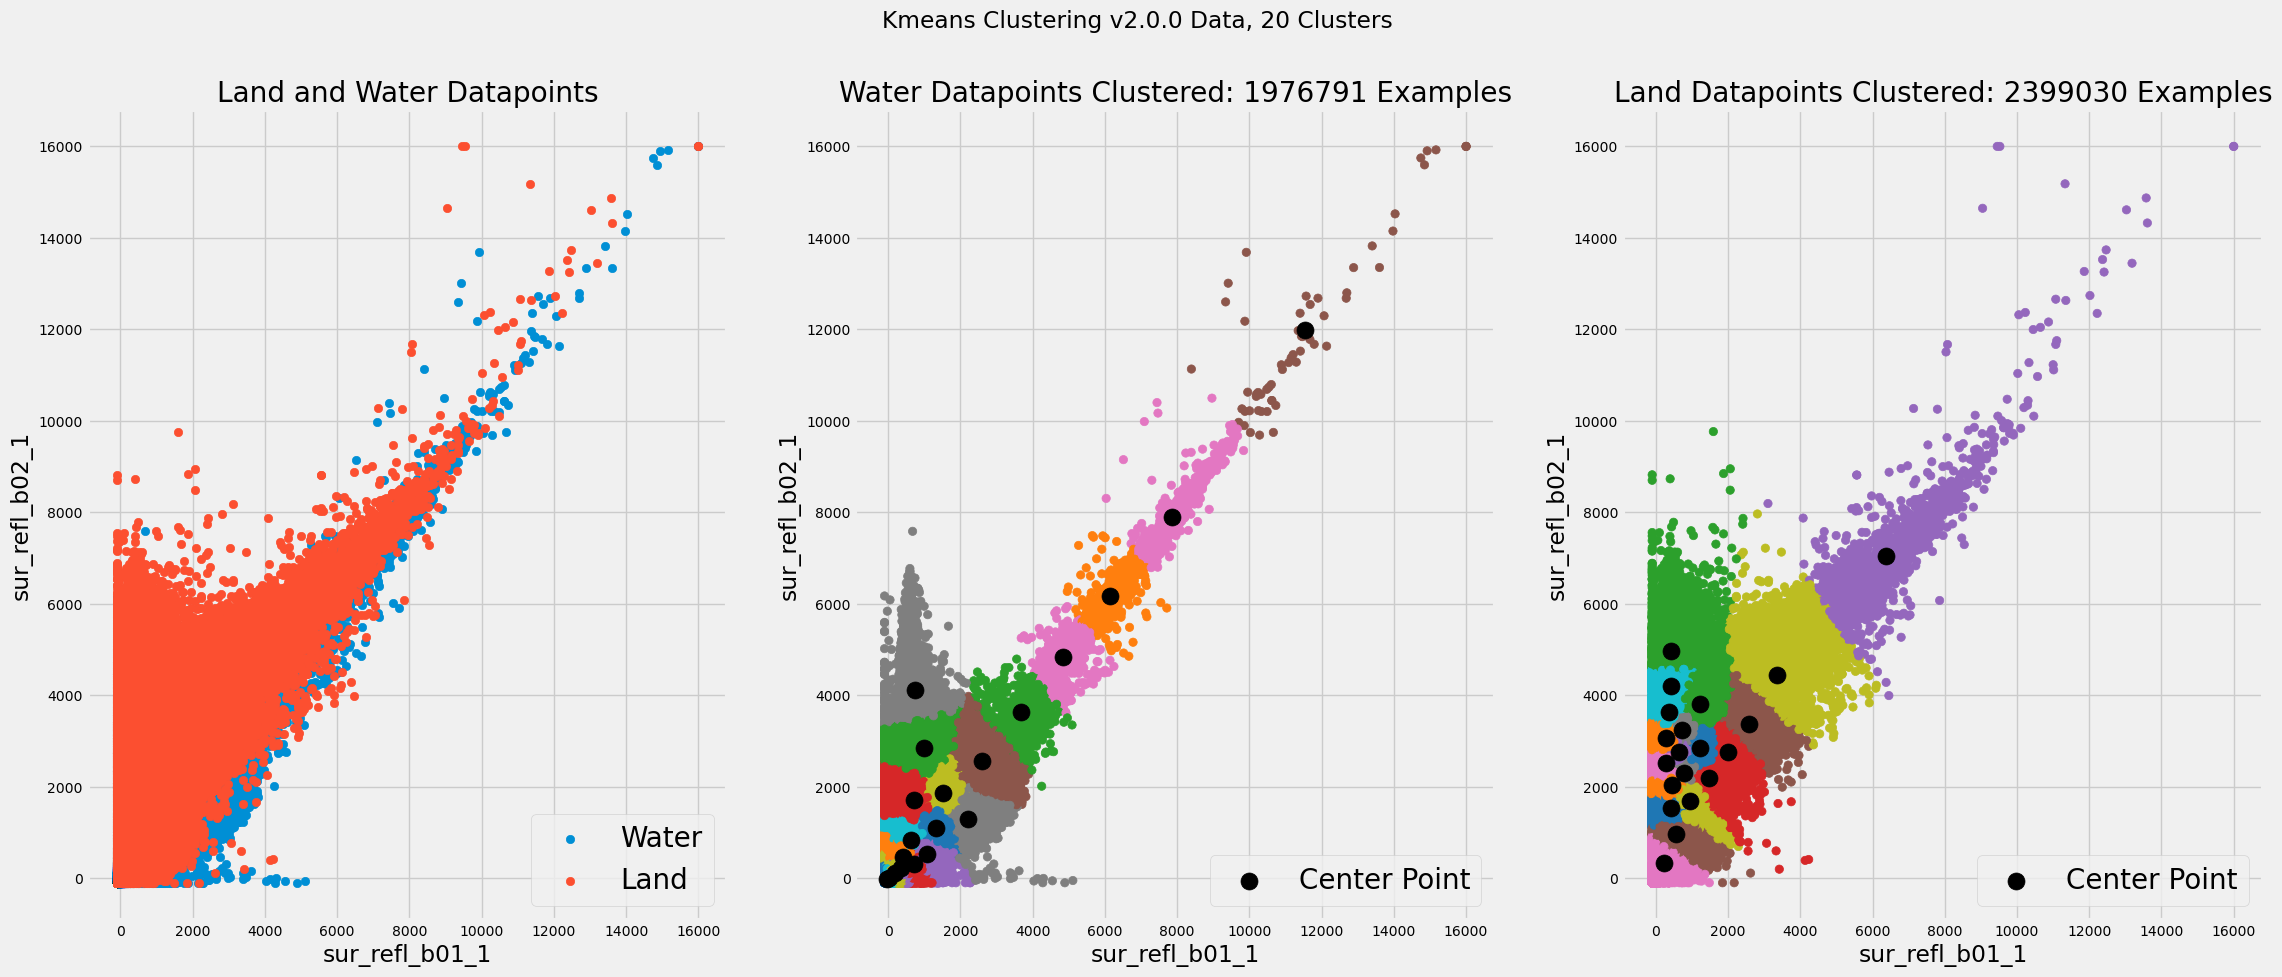

In [98]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 25

In [109]:
CLUSTER_NUM=25

In [110]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 1min 38s, sys: 11.7 s, total: 1min 50s
Wall time: 2.99 s


In [111]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 1min 24s, sys: 9.93 s, total: 1min 34s
Wall time: 2.54 s


In [112]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1977787
[17  9  9 ...  8  4 10]
[[-4.83157370e+01 -1.36918725e+01]
 [ 2.39714208e+03  1.97620994e+03]
 [ 5.08830587e+03  5.09982335e+03]
 [ 1.09844000e+03  5.35335990e+02]
 [ 4.57187765e+02  1.94372219e+02]
 [ 3.60836705e+02  9.72911326e+02]
 [ 1.47279217e+03  2.52259878e+03]
 [ 1.15876604e+04  1.20750566e+04]
 [ 8.99526068e+02  3.53118593e+03]
 [ 1.60994454e+02  5.73908655e+01]
 [ 1.05432563e+03  1.12313452e+03]
 [ 4.06293417e+03  4.03347878e+03]
 [ 7.52897216e+02  3.16290875e+02]
 [ 6.37063636e+03  6.41264176e+03]
 [ 7.78885779e+02  1.81954065e+03]
 [ 6.95150408e+02  7.10407010e+02]
 [ 1.50331314e+03  1.67476289e+03]
 [ 2.80954663e+01  8.19162165e-01]
 [ 6.31735294e+02  4.76345814e+03]
 [ 3.07336503e+03  3.03034224e+03]
 [ 4.23538353e+02  4.30918655e+02]
 [ 7.41803154e+02  2.68493101e+03]
 [ 1.54198114e+03  9.44676447e+02]
 [ 2.51209760e+02  2.08965018e+02]
 [ 8.04125577e+03  8.09989165e+03]]

land
2398034
[13 14 19 ...  5 18 18]
[[ 323.76069756 3536.85850001]
 [1296.66466361 1

25

##### 25 plot

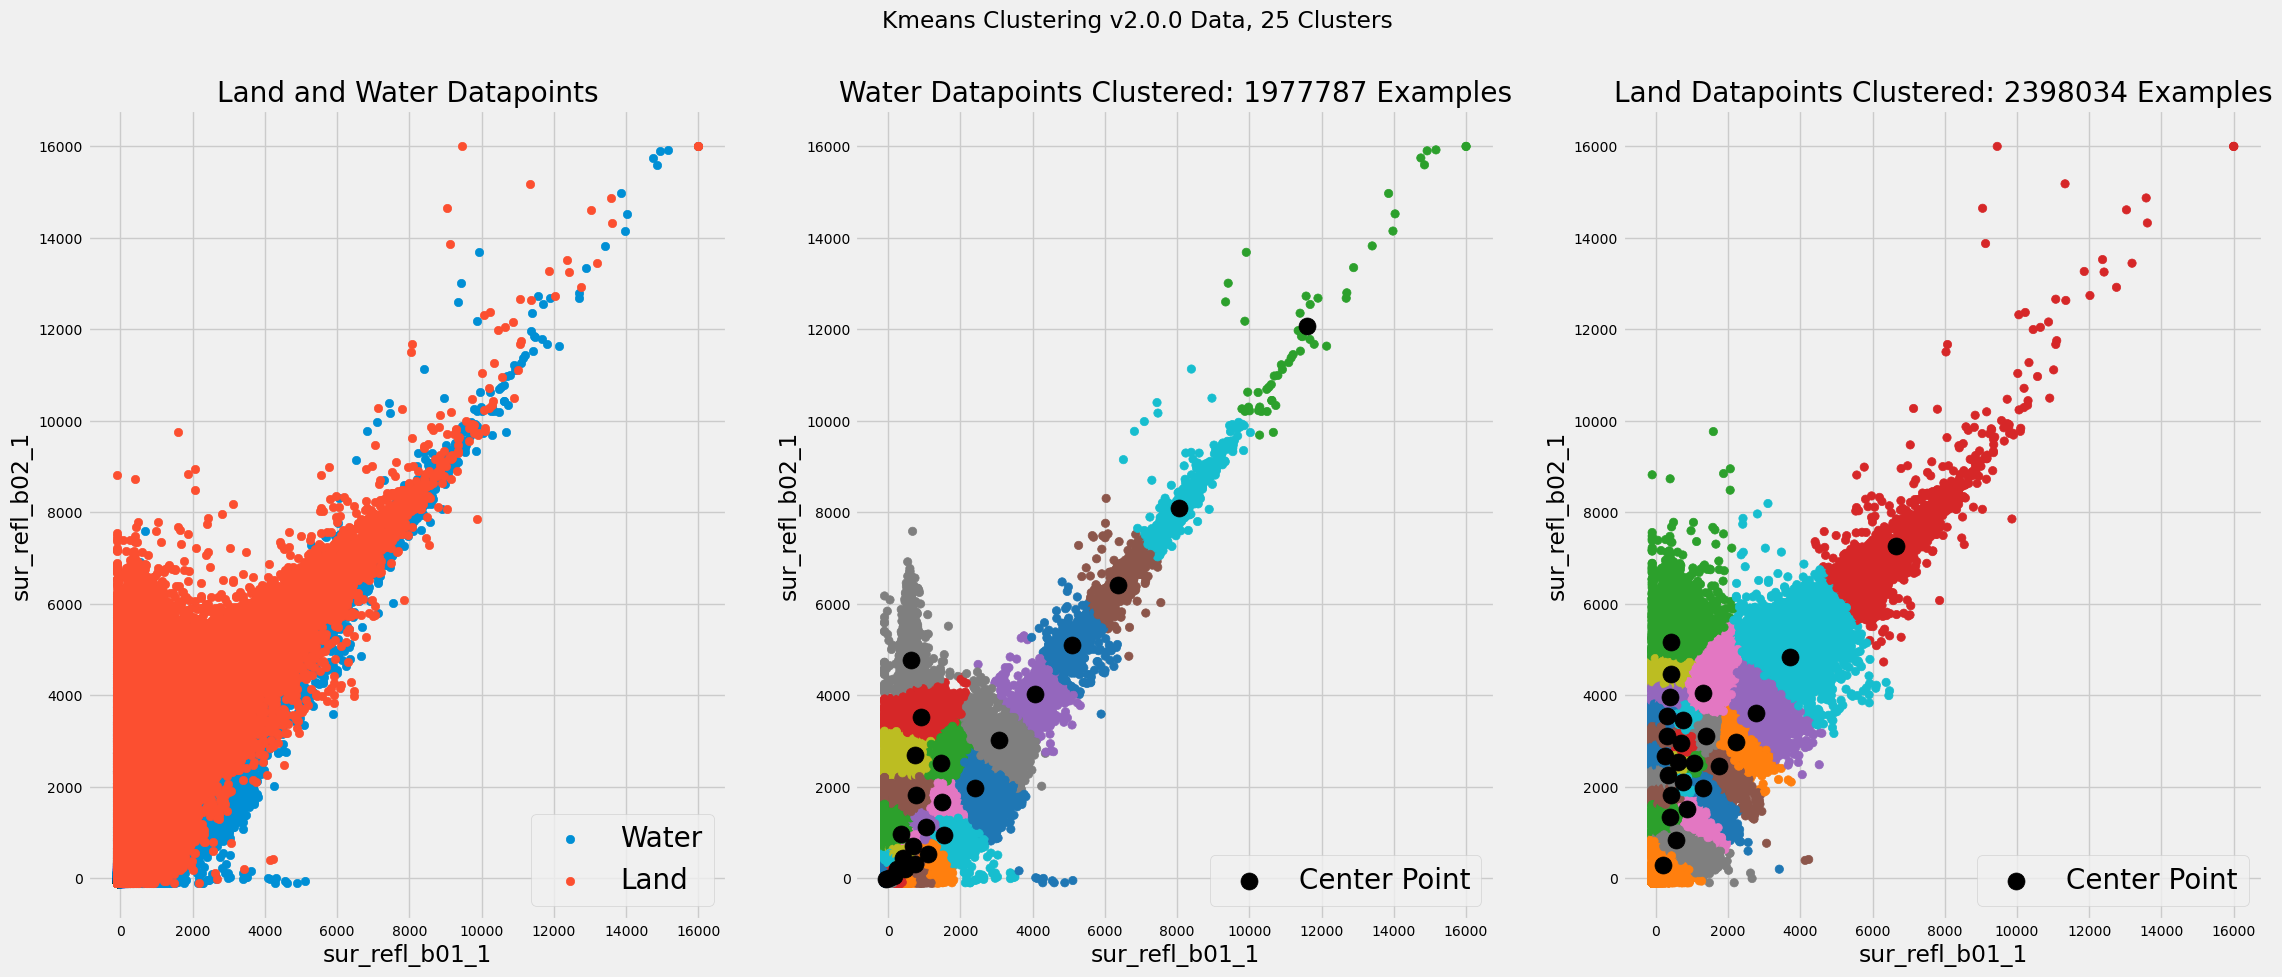

In [113]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 30

In [114]:
CLUSTER_NUM=30

In [115]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 1min 57s, sys: 13.6 s, total: 2min 11s
Wall time: 3.52 s


In [116]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 2min 5s, sys: 13.1 s, total: 2min 19s
Wall time: 3.69 s


In [117]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1977787
[ 0 17 29 ...  8  9 27]
[[ 2.44237638e+01  2.22699023e-01]
 [ 1.92054292e+03  2.05440452e+03]
 [ 5.53965731e+03  5.55379847e+03]
 [ 1.11357133e+03  5.52583966e+02]
 [ 5.20110628e+02  4.50039479e+02]
 [ 5.09815761e+02  1.40665751e+03]
 [ 1.42015155e+03  2.87744444e+03]
 [ 1.16837600e+04  1.21964200e+04]
 [ 7.95051181e+02  3.58524553e+03]
 [ 3.21662086e+02  1.33833308e+02]
 [ 1.49855712e+03  9.02776259e+02]
 [ 3.65330876e+03  3.61731707e+03]
 [ 8.13529774e+02  3.34011631e+02]
 [ 6.68111269e+03  6.72935824e+03]
 [ 1.11295963e+03  2.01552904e+03]
 [ 7.19388629e+02  7.61672693e+02]
 [ 1.48300890e+03  1.53542354e+03]
 [ 1.31135406e+02  2.11812194e+01]
 [ 6.36684864e+02  4.82329529e+03]
 [ 2.80790782e+03  2.72072481e+03]
 [ 3.11112436e+02  7.25465884e+02]
 [ 6.90436785e+02  2.63434708e+03]
 [ 2.64525411e+03  1.37316249e+03]
 [ 3.20793672e+02  3.19194107e+02]
 [ 8.20091239e+03  8.26795085e+03]
 [-5.13683520e+01 -1.45951558e+01]
 [ 5.46251507e+02  2.17540812e+02]
 [ 1.06967718e+03

30

##### 30 plot

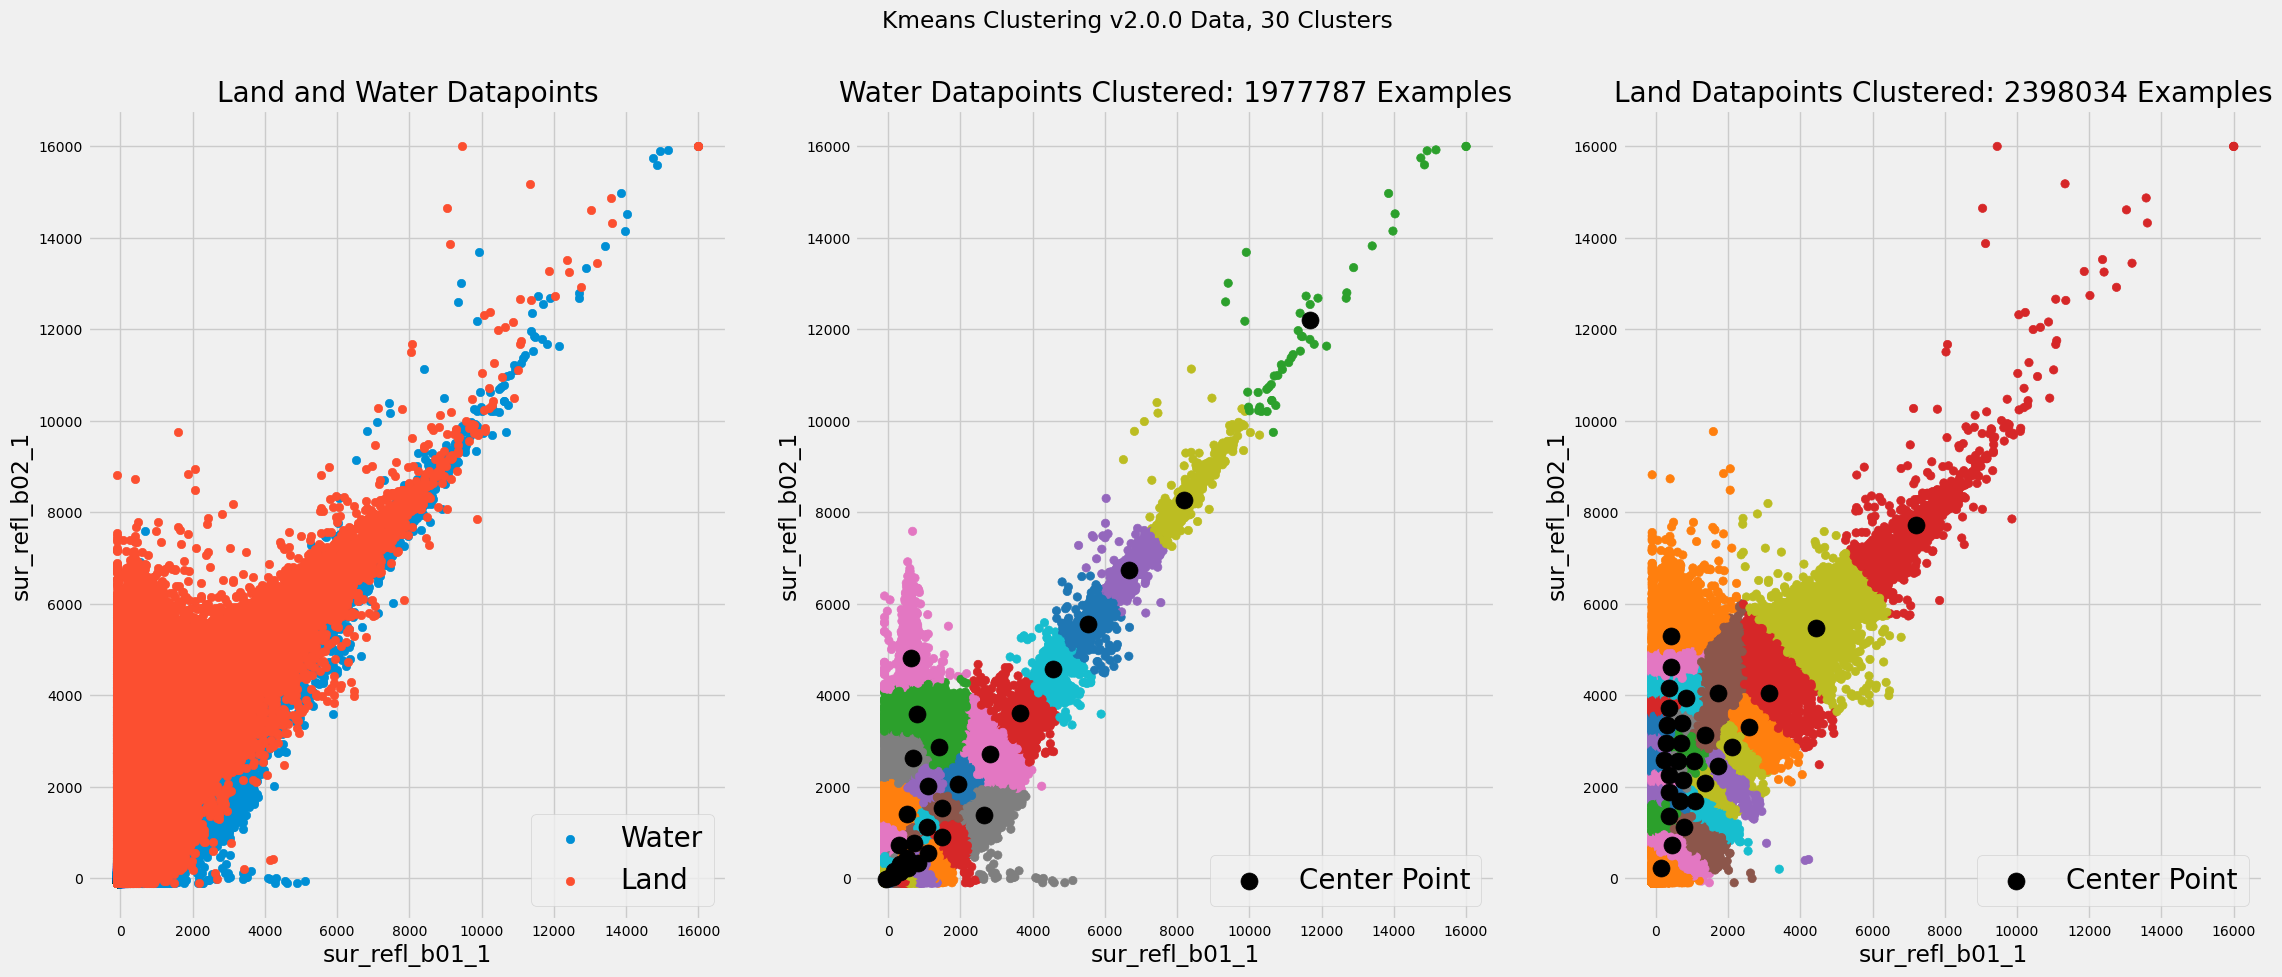

In [118]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

## Adding more input bands

In [49]:
colsToDrop = [
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [50]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

Imbalancing data, sampling 0.5 from land, 0.5 from water
subset data shape: (100, 3), (100,)


In [55]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind_3D = np.where(y>0.5)[0]
y_land_ind_3D = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_3D = X.iloc[y_water_ind_3D,:]
y_water_3D = y.iloc[y_water_ind_3D]

X_land_3D = X.iloc[y_land_ind_3D,:]
y_land_3D = y.iloc[y_land_ind_3D]

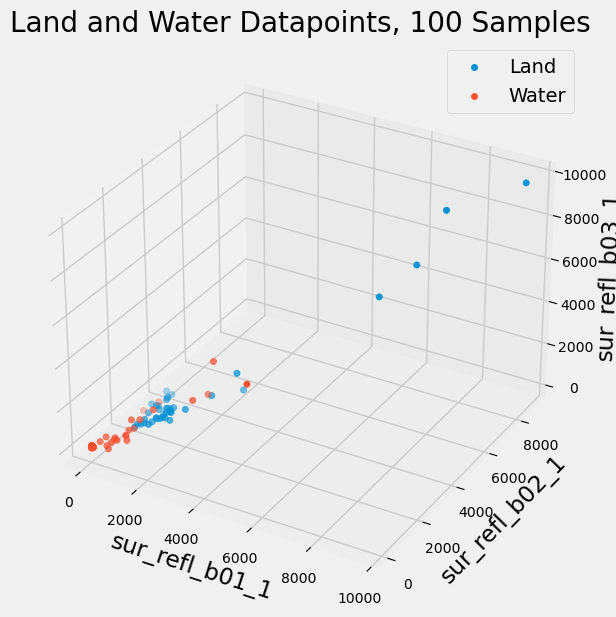

In [66]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
ax.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],label='Land')
ax.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],label='Water')

ax.set_xlabel(X_land.columns[0])
ax.set_ylabel(X_land.columns[1])
ax.set_zlabel(X_land.columns[2])
plt.legend()

plt.show()

### Kmeans

In [88]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [89]:
%%time
kme_water_3D =  KMeans(n_clusters=5, **common_params).fit(X_water_3D)
kmeans_output_water_3D = kme_water_3D.predict(X_water_3D)

CPU times: user 65.2 ms, sys: 9.15 ms, total: 74.4 ms
Wall time: 6.91 ms


In [90]:
%%time
kme_land_3D =  KMeans(n_clusters=5, **common_params).fit(X_land_3D)
kmeans_output_land_3D = kme_land_3D.predict(X_land_3D)

CPU times: user 56 ms, sys: 8.16 ms, total: 64.1 ms
Wall time: 5.57 ms


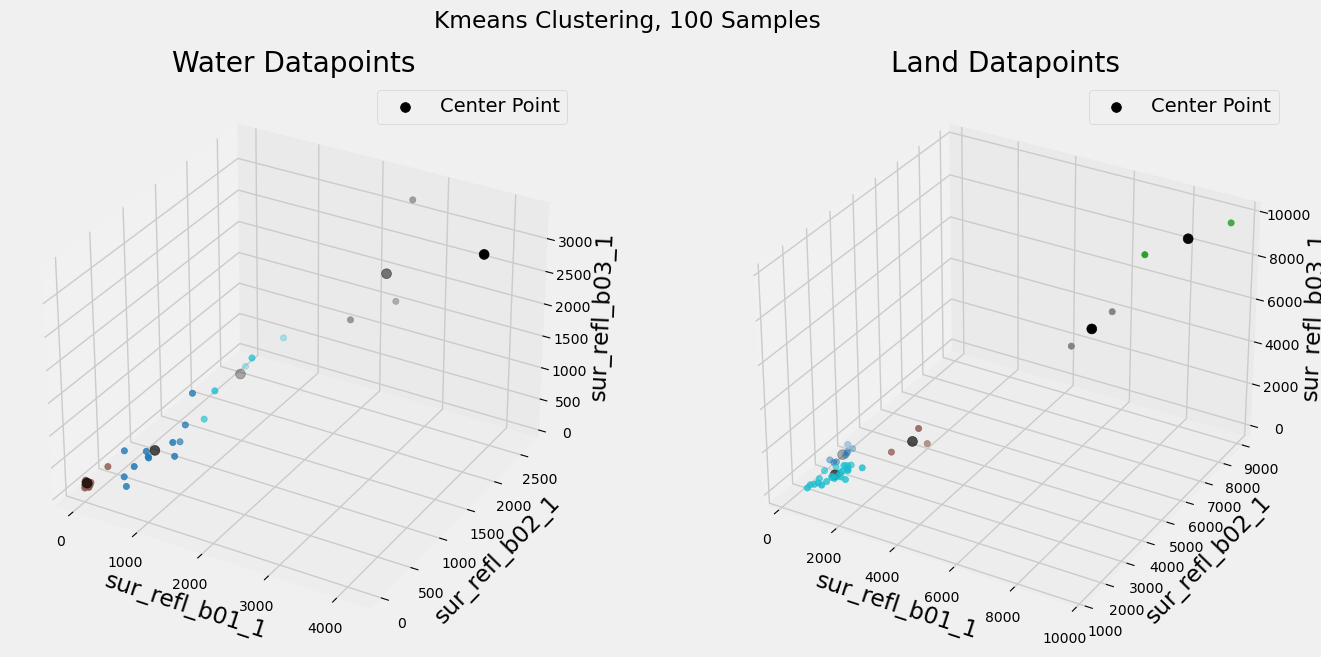

In [93]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'Kmeans Clustering, {num_datapoints} Samples')
ax1 = plt.subplot(121,projection ="3d")
# ax1 = plt.axes(projection ="3d")
ax1.set_title(f'Water Datapoints')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

ax1.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],
           marker='o',c=kmeans_output_water_3D,cmap='tab10')
ax1.scatter(kme_water_3D.cluster_centers_[:,0],kme_water_3D.cluster_centers_[:,1],kme_water_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax1.legend()
ax1.set_xlabel(X_water_3D.columns[0])
ax1.set_ylabel(X_water_3D.columns[1])
ax1.set_zlabel(X_water_3D.columns[2])


ax2 = plt.subplot(122,projection ="3d")
# ax2 = plt.axes(projection ="3d")
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='minor', labelsize=10)

ax2.set_title(f'Land Datapoints')
ax2.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],
           marker='o',c=kmeans_output_land_3D,cmap='tab10')
ax2.scatter(kme_land_3D.cluster_centers_[:,0],kme_land_3D.cluster_centers_[:,1],kme_land_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax2.legend()
ax2.set_xlabel(X_land_3D.columns[0])
ax2.set_ylabel(X_land_3D.columns[1])
ax2.set_zlabel(X_land_3D.columns[2])

plt.show()

### Birch

In [74]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

CPU times: user 12.4 ms, sys: 11 ms, total: 23.4 ms
Wall time: 27.3 ms


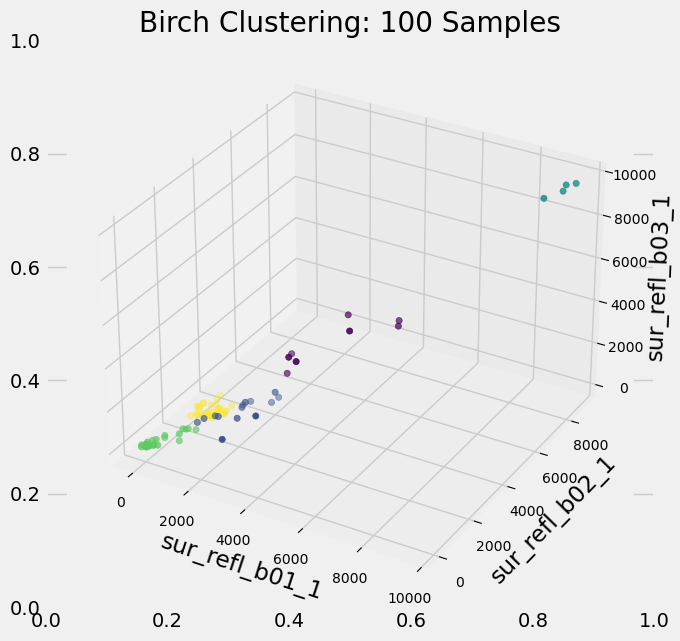

In [76]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Birch Clustering: {num_datapoints} Samples')
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o',c=birch_output)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()

## Comparing targeted and random samples


In [11]:
DATA_VERSION='v4.2.1'
training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

#VERSION 4.2.1
TILE_IN = 'Golden'#v4.2.1
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)


X_target, X_test_target, y_target, y_test_target = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                trainTestSplit=True
                                )

X_target = X_target.iloc[:num_datapoints,:] 
y_target = y_target.iloc[:num_datapoints] 

X_test_target = X_test_target.iloc[:num_datapoints,:] 
y_test_target = y_test_target.iloc[:num_datapoints] 

print(f'\n\ntarget subset data shape: {X_target.shape}, {y_target.shape}')

#Getting the indices that are associated with land (0) and water (1)
#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_target = X_target.iloc[np.where(y_target>0.5)[0],:]
X_land_target = X_target.iloc[np.where(y_target<0.5)[0],:]

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.1/MOD09_Golden_Masked_986161_4_2_1.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.1/MOD09_Golden_Masked_986161_4_2_1.parquet.gzip


target subset data shape: (788928, 3), (788928,)


In [16]:
DATA_VERSION='v2.0.1'
training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

#VERSION 4.2.0
TILE_IN = 'GLOBAL'#v4.2.0
offsets_indexes_rand = ['x_offset', 'y_offset', 'year', 'julian_day']

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes_rand)

X_rand, X_test_rand, y_rand, y_test_rand = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                trainTestSplit=True
                                )

X_rand = X_rand.iloc[:num_datapoints,:] 
y_rand = y_rand.iloc[:num_datapoints] 

X_test_rand = X_test_rand.iloc[:num_datapoints,:] 
y_test_rand = y_test_rand.iloc[:num_datapoints] 

print(f'\n\nrandom subset data shape: {X_rand.shape}, {y_rand.shape}')

#Getting the indices that are associated with land (0) and water (1)
#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_rand = X_rand.iloc[np.where(y_rand>0.5)[0],:]
X_land_rand = X_rand.iloc[np.where(y_rand<0.5)[0],:]


['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip


random subset data shape: (4375821, 3), (4375821,)


In [ ]:
# df.drop(df[df['Fee'] >= 24000].index, inplace = True)

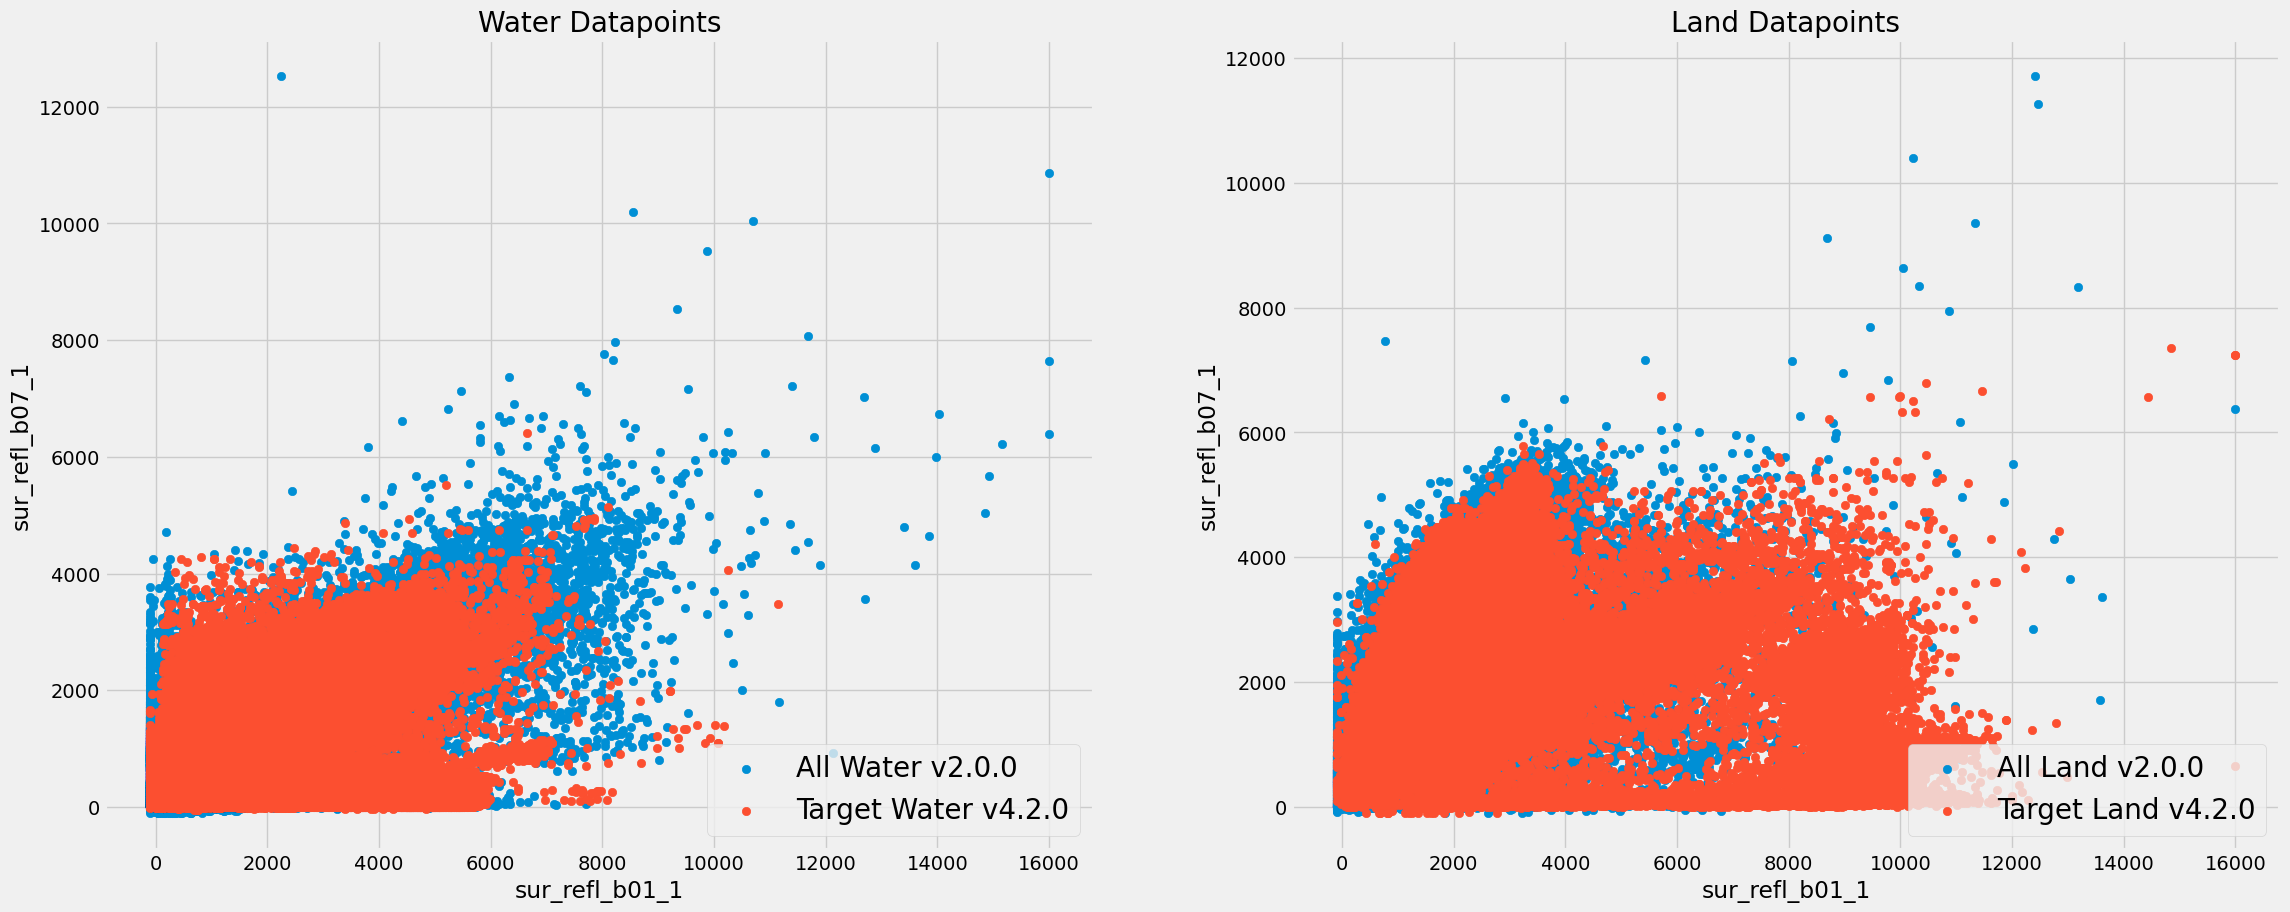

In [18]:
fig = plt.figure(figsize = (25, 10))

ax = plt.subplot(121)
ax.set_title(f'Water Datapoints')
ax.scatter(X_water_rand.values[:,0],X_water_rand.values[:,2],label=f'All Water v2.0.0')
ax.scatter(X_water_target.values[:,0],X_water_target.values[:,2],label=f'Target Water v4.2.0')
ax.legend(loc='lower right',fontsize="20")
ax.set_xlabel(X_land_rand.columns[0])
ax.set_ylabel(X_land_rand.columns[2])

ax1 = plt.subplot(122)
ax1.set_title(f'Land Datapoints')
ax1.scatter(X_land_rand.values[:,0],X_land_rand.values[:,2],label=f'All Land v2.0.0')
ax1.scatter(X_land_target.values[:,0],X_land_target.values[:,2],label=f'Target Land v4.2.0')
ax1.legend(loc='lower right',fontsize="20")
ax1.set_xlabel(X_land_rand.columns[0])
ax1.set_ylabel(X_land_rand.columns[2])

plt.show()

### Birch

In [46]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

MemoryError: unable to allocate array data.

Text(0, 0.5, 'sur_refl_b02_1')

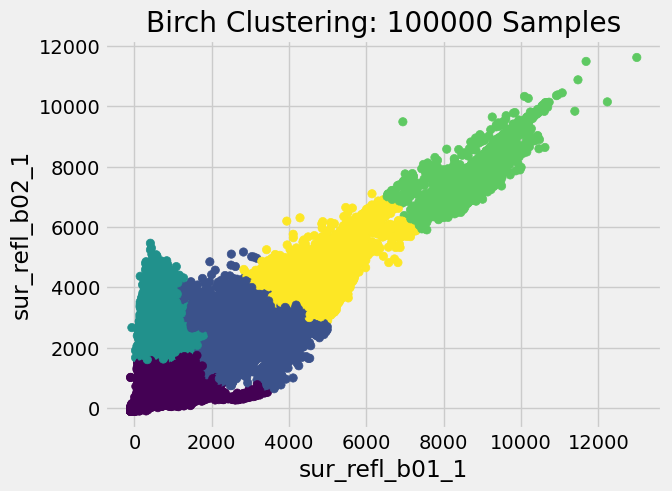

In [39]:
plt.scatter(X.values[:,0], X.values[:,1],c=birch_output)
plt.title(f'Birch Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

### Spectral 

In [17]:
%%time
spectral = SpectralClustering(
        n_clusters=5,
        #affinity="nearest_neighbors",
        random_state=42).fit_predict(X)

CPU times: user 42min 33s, sys: 3min 47s, total: 46min 21s
Wall time: 1min 10s


Text(0, 0.5, 'sur_refl_b02_1')

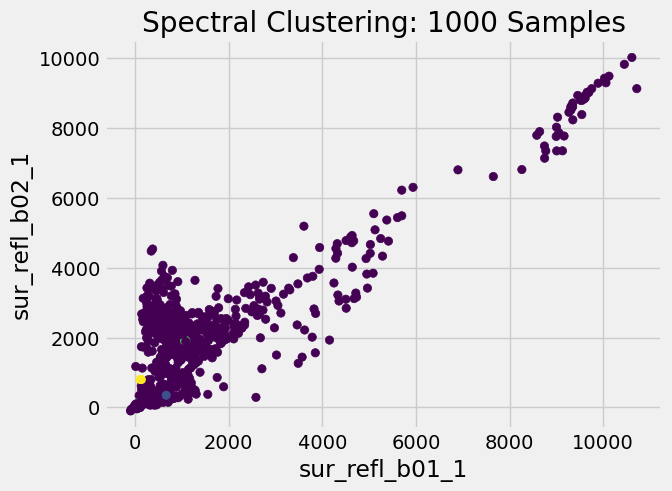

In [20]:
plt.scatter(X.values[:,0], X.values[:,1],c=spectral)
plt.title(f'Spectral Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

## Selecting Clustered Training Data

Based on the cluster analysis above on 5.03.23, 15 clusters appears to have the most data and exclude outliers so will use that number for selection 

In [40]:
CLUSTER_NUM=15

In [41]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [42]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 1min 2s, sys: 6.58 s, total: 1min 8s
Wall time: 1.98 s


In [43]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 1min 2s, sys: 6.67 s, total: 1min 8s
Wall time: 1.91 s


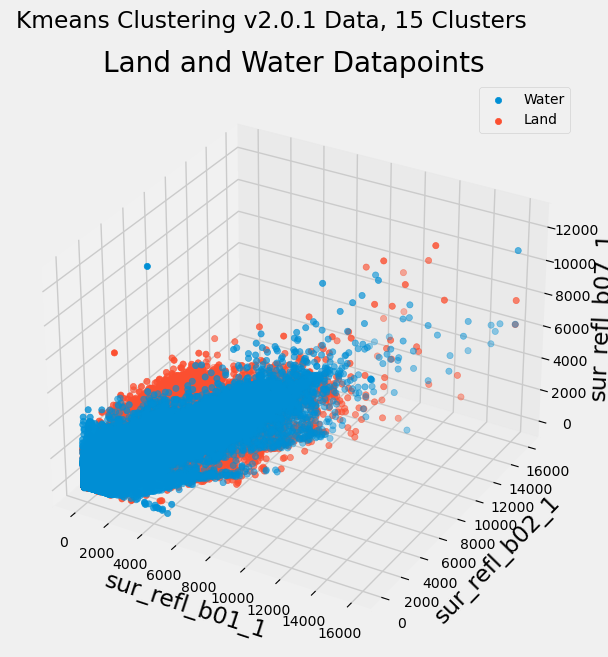

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


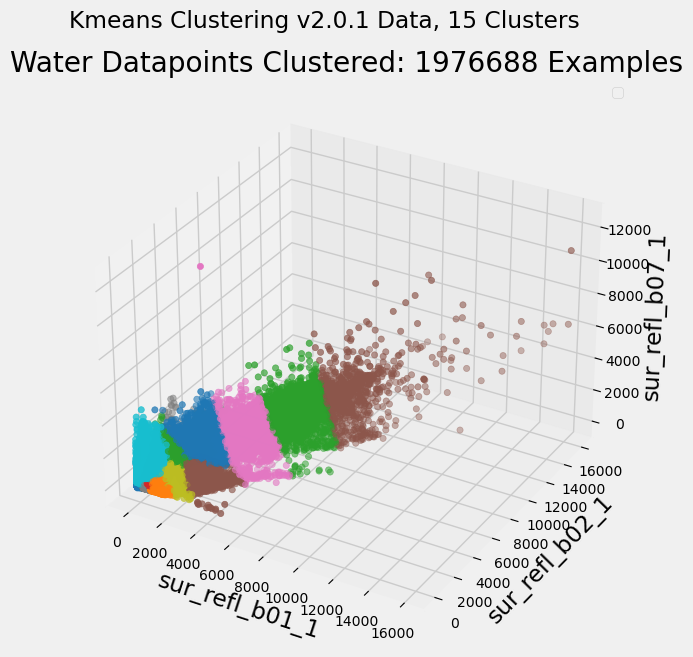

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


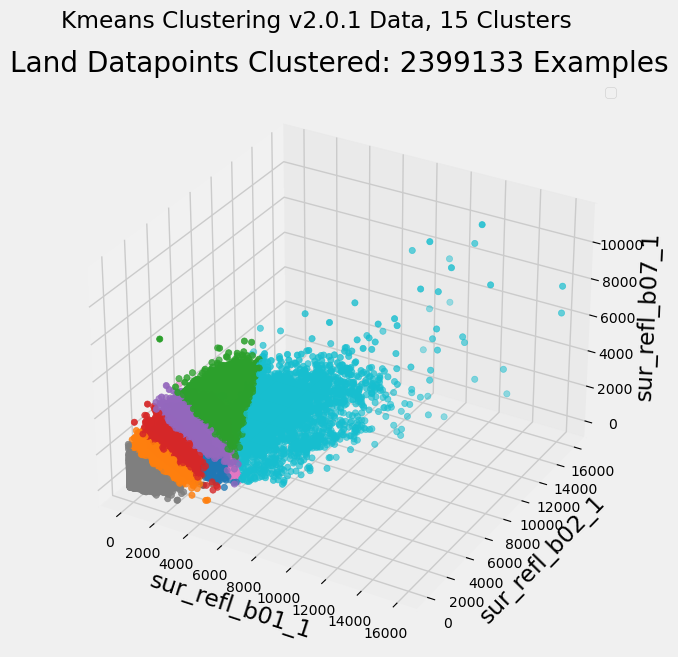

In [44]:
plotting_3d(X_water,X_land,CLUSTER_NUM)
axtitle_water = f'Water Datapoints Clustered: {len(X_water)} Examples'
plotting_clusters_3d(X_water,kme_water,kmeans_output_water,CLUSTER_NUM,axtitle_water)
axtitle_land = f'Land Datapoints Clustered: {len(X_land)} Examples'
plotting_clusters_3d(X_land,kme_land,kmeans_output_land,CLUSTER_NUM,axtitle_land)

In [45]:
# List of the clusters: kmeans_output_land and kmeans_output_water
# Data: X_water, X_land, y_water, y_land

PERCENT_RANDOM_PULL = 0.15

In [46]:
np.random.seed(42)
random_ind_land = np.array([])
random_ind_water = []

for cluster in np.unique(kmeans_output_land):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water == cluster)[0]
    COUNT_RANDOM_PULL_WATER = int(PERCENT_RANDOM_PULL*len(cluster_ind_water))
    random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
    max_X_random_water = np.nanmax(X_water.iloc[random_pts_water])
    if max_X_random_water < 10000:
        random_ind_water = np.append(random_ind_water, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    cluster_ind_land = np.where(kmeans_output_land == cluster)[0]
    COUNT_RANDOM_PULL_LAND = int(PERCENT_RANDOM_PULL*len(cluster_ind_land))
    random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
    random_ind_land = np.append(random_ind_land, random_pts_land)
    print(f'Pulling {COUNT_RANDOM_PULL_WATER} Water pts and {COUNT_RANDOM_PULL_LAND} Land pts')
    print()
random_ind_water = random_ind_water.astype('int')
random_ind_land = random_ind_land.astype('int')

print(random_ind_water,random_ind_land)

cluster 0
Pulling 212407 Water pts and 17456 Land pts

cluster 1
Pulling 732 Water pts and 38939 Land pts

cluster 2
Pulling 7844 Water pts and 25041 Land pts

cluster 3
Pulling 326 Water pts and 32709 Land pts

cluster 4
Pulling 1974 Water pts and 8254 Land pts

cluster 5
Pulling 18001 Water pts and 21402 Land pts

cluster 6
Pulling 4426 Water pts and 17853 Land pts

cluster 7
Pulling 966 Water pts and 38376 Land pts

cluster 8
Cluster 8 contains outliers
Pulling 115 Water pts and 40992 Land pts

cluster 9
Pulling 473 Water pts and 15454 Land pts

cluster 10
Pulling 28610 Water pts and 27693 Land pts

cluster 11
Pulling 978 Water pts and 18794 Land pts

cluster 12
Pulling 3074 Water pts and 41611 Land pts

cluster 13
Pulling 13710 Water pts and 546 Land pts

cluster 14
Pulling 2858 Water pts and 14744 Land pts

[ 306241  407243 1157472 ...   86176  450107 1208602] [2314166  658871  697140 ...   73777  627342 1096153]


### Total random dataset used for training random forest

In [64]:
X_cluster_land = X_land.iloc[random_ind_land]
y_cluster_land = y_land.iloc[random_ind_land]
X_cluster_water = X_water.iloc[random_ind_water]
y_cluster_water = y_water.iloc[random_ind_water]

X_cluster = pd.concat([X_cluster_land,X_cluster_water])
y_cluster = pd.concat([y_cluster_land,y_cluster_water])

#Combine the data so that we can shuffle the indices and keep the data together that should be
All_data = pd.concat([X_cluster,y_cluster],axis=1).sample(frac=1)

X_cluster_rfa = All_data[X_cluster.columns]
y_cluster_rfa = All_data['water']

In [65]:
print(len(X_cluster_land),len(X_cluster_water))

359864 296379


In [66]:
print(All_data)
print(X_cluster_rfa)
print(y_cluster_rfa)

         sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1  water
4743784             597            5295            1074      0
2112478             -75              -4              40      1
4157839             212            3874             514      0
3529711             -15              -4              11      1
3259071             555            1318            1543      0
...                 ...             ...             ...    ...
4334939             962            2685            1341      0
2371923             -74             -33              54      1
785094              330            4237             754      0
1459433             966            2509            1476      0
1208529             522             234             223      0

[656243 rows x 4 columns]
         sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1
4743784             597            5295            1074
2112478             -75              -4              40
4157839             212            3874          

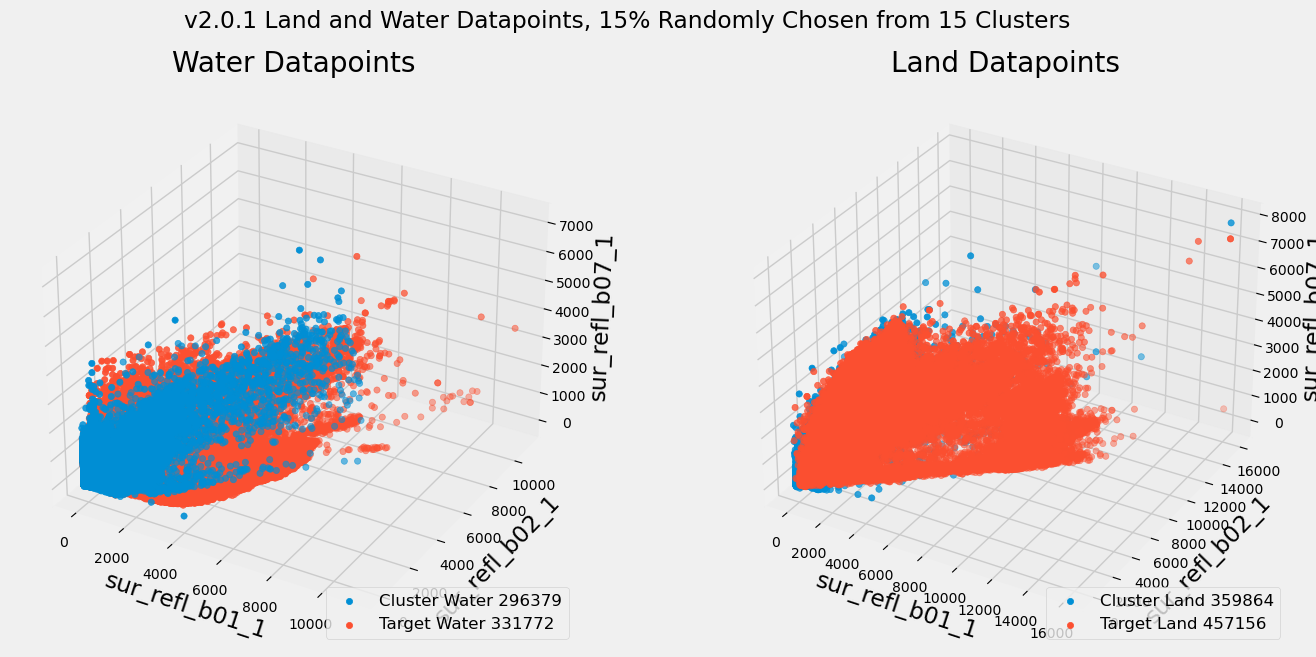

In [68]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'{DATA_VERSION} Land and Water Datapoints,'+ 
    f' {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')

ax = plt.subplot(121,projection='3d')
#No random sample
# ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
#Randomly sampled data
ax.set_title('Water Datapoints')
ax.scatter(X_cluster_water.values[:,0], X_cluster_water.values[:,1], X_cluster_water.values[:,2],label=f'Cluster Water {len(y_random_water)}')
ax.scatter(X_water_target.values[:,0], X_water_target.values[:,1], X_water_target.values[:,2],label=f'Target Water {len(X_water_target)}')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(loc='lower right',fontsize="12")
ax.set_xlabel(X_random_water.columns[0])
ax.set_ylabel(X_random_water.columns[1])
ax.set_zlabel(X_random_water.columns[2])

ax1 = plt.subplot(122,projection='3d')
ax1.set_title('Land Datapoints')
ax1.scatter(X_cluster_land.values[:,0], X_cluster_land.values[:,1], X_cluster_land.values[:,2],label=f'Cluster Land {len(y_random_land)}')
ax1.scatter(X_land_target.values[:,0], X_land_target.values[:,1], X_land_target.values[:,2],label=f'Target Land {len(X_land_target)}')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)
ax1.legend(loc='lower right',fontsize="12")
ax1.set_xlabel(X_random_water.columns[0])
ax1.set_ylabel(X_random_water.columns[1])
ax1.set_zlabel(X_random_water.columns[2])

plt.show()

In [32]:

# ax = plt.subplot(111)

# #No random sample
# ax.hist(X_water.values[:,0],label=f'All Water {len(y_water)}',alpha=0.8)
# ax.hist(X_land.values[:,0],label=f'All Land {len(y_land)}', alpha=0.8)
# ax.hist(X_random_water.values[:,0],label=f'Samp Water {len(y_random_water)}', alpha=0.8)
# ax.hist(X_random_land.values[:,0], label=f'Samp Land {len(y_random_land)}',alpha=0.8) 
# # ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
# # #Randomly sampled data
# # ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label=f'Samp Water {len(y_random_water)}')
# # ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label=f'Samp Land {len(y_random_land)}')

# ax.set_title(f'{DATA_VERSION} Land and Water Datapoints'+ 
#     f'\n {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.legend(loc='lower right',fontsize="12")
# ax.set_xlabel(X_random_water.columns[0])
# # ax.set_ylabel(X_random_water.columns[1])

# plt.show()

https://medium.com/@prasadostwal/multi-dimension-plots-in-python-from-2d-to-6d-9a2bf7b8cc74 for adding in more dimensions for plotting

# Random forest training Cluster Data

In [69]:
import optuna
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.inspection import permutation_importance


#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal
from pprint import pprint

In [52]:
FIGURE_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

TILE = 'h11v10'
DAY = 201
YEAR = 2006

# TILE = 'h21v10'
# DAY = 100
# YEAR = 2019

FRAC_LAND = 0.5

##Add in the other stuff for tuning
frac_water = int(100*(1.0-FRAC_LAND))
if len(colsToDrop) >= 1:
    save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_no-vars_{'-'.join(colsToDrop)}"
else: 
     save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_all-vars"

print(save_file)

h11v10_201_2006_frac-water50_no-vars_sur_refl_b03_1-sur_refl_b04_1-sur_refl_b05_1-sur_refl_b06_1-ndvi-ndwi1-ndwi2


#### RF FUNCTIONS

In [61]:
def rf_objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
    
    # if TREES_AND_DEPTH_ONLY:
    #     param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
    #                'criterion':'gini', 
    #                'max_depth':trial.suggest_categorical('max_depth', max_depth), 
    #                'min_samples_split':2, 
    #                'min_samples_leaf':1, 
    #                'min_weight_fraction_leaf':0.0, 
    #                'max_features':'auto', 
    #                'max_leaf_nodes':None, 
    #                'min_impurity_decrease':0.0, 
    #                'bootstrap':True, 
    #                'oob_score':False, 
    #                'n_jobs':-1, 
    #                # 'random_state':42, 
    #                'verbose':0, 
    #                'warm_start':True, 
    #                'class_weight':None, 
    #                'ccp_alpha':0.0, 
    #                'max_samples':None
    #                   }
    # else:
    param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': trial.suggest_categorical('bootstrap', bootstrap),
                       'criterion':'gini', 
                       #'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 1e-8, 1.0, log=True), 
                       'max_features':trial.suggest_categorical('max_features', max_features), 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       # 'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #######################
    # HERE IS WHERE TO CHANGE THE X,Y DATASET USED FOR TRAINING
    #######################
    
    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X_random_rfa, y_random_rfa)):
        X_train, X_val = X_random_rfa.iloc[train_idx], X_random_rfa.iloc[val_idx]
        y_train, y_val = y_random_rfa.iloc[train_idx], y_random_rfa.iloc[val_idx]

        model = skRF(**param)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

search_space={
    "n_estimators": [75, 100, 125, 150, 175, 200, 250, 300, 400, 500],
    "max_depth" : [5,10, 30, 50, 80, 90, 100, 110],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "min_samples_split" : [2, 4, 8, 10],
    "bootstrap" : [True, False],
    "max_features" : ['auto', 'sqrt', 'log2'],
    
}

In [54]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'): os.remove('tmp.vrt')
    
    return img

In [55]:
def predictRaster(img_chunk, classifier, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [56]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 


# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

#### Training RF

In [57]:
TREES_AND_DEPTH_ONLY = False
GRID_SEARCH = True

In [62]:
%%time

optuna.logging.set_verbosity(optuna.logging.INFO)
if GRID_SEARCH:
    study = optuna.create_study(study_name='RF Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(search_space))
    
else:
    study = optuna.create_study(study_name='RF Tuning',
                                direction='maximize')
#Objective is under the functions area

#####################################################################
#CHANGE HERE FOR DIFFERENT MODELING TYPE
#rf_objective or xgb_objective
#####################################################################

study.optimize(rf_objective, n_trials=25, timeout=30*60)

[I 2023-05-04 16:45:51,855] A new study created in memory with name: RF Tuning Grid Search


Fold 0: 0.9700539926597107
Fold 1: 0.970354608726613
Fold 2: 0.9705642835329646
Fold 3: 0.9709708861295927


[I 2023-05-04 16:46:08,797] Trial 0 finished with value: 0.9704930472331895 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9704930472331895.


Fold 4: 0.9705214651170669
Fold 0: 0.9762380410502803
Fold 1: 0.9760517908472489
Fold 2: 0.9764932042764156
Fold 3: 0.9765622365359323


[I 2023-05-04 16:46:29,102] Trial 1 finished with value: 0.97621149243096 and parameters: {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 1 with value: 0.97621149243096.


Fold 4: 0.9757121894449223
Fold 0: 0.9765999055903971
Fold 1: 0.9764587881290931
Fold 2: 0.9770140141997066
Fold 3: 0.9773715981519577


[I 2023-05-04 16:46:48,913] Trial 2 finished with value: 0.9767332202145346 and parameters: {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 2 with value: 0.9767332202145346.


Fold 4: 0.9762217950015178
Fold 0: 0.9766253909114664
Fold 1: 0.976641855838693
Fold 2: 0.9773886935033609
Fold 3: 0.9775072502866393


[I 2023-05-04 16:47:15,558] Trial 3 finished with value: 0.9769204461123495 and parameters: {'n_estimators': 175, 'max_depth': 80, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9769204461123495.


Fold 4: 0.9764390400215878
Fold 0: 0.9700562240822246
Fold 1: 0.9702350666530987
Fold 2: 0.9708000745674241
Fold 3: 0.9707237204883057


[I 2023-05-04 16:47:23,468] Trial 4 finished with value: 0.9704124834077124 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9769204461123495.


Fold 4: 0.9702473312475092
Fold 0: 0.9762113497656538
Fold 1: 0.9760732472262503
Fold 2: 0.9764857641494321
Fold 3: 0.9766520232383619


[I 2023-05-04 16:47:48,249] Trial 5 finished with value: 0.9761745870996761 and parameters: {'n_estimators': 125, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9769204461123495.


Fold 4: 0.9754505511186824
Fold 0: 0.9765661878751096
Fold 1: 0.9765661878751096
Fold 2: 0.9771728772968369
Fold 3: 0.9774626274208916


[I 2023-05-04 16:48:24,603] Trial 6 finished with value: 0.9767991805123609 and parameters: {'n_estimators': 200, 'max_depth': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 3 with value: 0.9769204461123495.


Fold 4: 0.9762280220938567
Fold 0: 0.9700679003450119
Fold 1: 0.9703865098810543
Fold 2: 0.9703789059852234
Fold 3: 0.9707715397725827


[I 2023-05-04 16:48:57,025] Trial 7 finished with value: 0.9703626590462916 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9769204461123495.


Fold 4: 0.970208439247585
Fold 0: 0.9766818411734952
Fold 1: 0.9766155817443055
Fold 2: 0.9772598881965582
Fold 3: 0.9775154912953674


[I 2023-05-04 16:49:33,160] Trial 8 finished with value: 0.9769244912524085 and parameters: {'n_estimators': 250, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9765496538523158
Fold 0: 0.9760914848579404
Fold 1: 0.976161364038823
Fold 2: 0.9768069494813191
Fold 3: 0.9768112277152611


[I 2023-05-04 16:49:56,374] Trial 9 finished with value: 0.9763435644796464 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9758467963048887
Fold 0: 0.9701073828916255
Fold 1: 0.9701932858596135
Fold 2: 0.970562058706358
Fold 3: 0.9706772462551817


[I 2023-05-04 16:50:07,484] Trial 10 finished with value: 0.9703606566423153 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9702633094987971
Fold 0: 0.9763642800546217
Fold 1: 0.9763952116000674
Fold 2: 0.9766034045208124
Fold 3: 0.9768637965632957


[I 2023-05-04 16:51:16,872] Trial 11 finished with value: 0.976384239149915 and parameters: {'n_estimators': 400, 'max_depth': 110, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9756945030107781
Fold 0: 0.9766555663280361
Fold 1: 0.9764913138396959
Fold 2: 0.9773535908807311
Fold 3: 0.9773143035381594


[I 2023-05-04 16:51:29,042] Trial 12 finished with value: 0.9768392359794443 and parameters: {'n_estimators': 75, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9763814053106001
Fold 0: 0.976690074945835
Fold 1: 0.9766673410209723
Fold 2: 0.9772062233840705
Fold 3: 0.9775473209392521


[I 2023-05-04 16:52:05,413] Trial 13 finished with value: 0.9769138495901935 and parameters: {'n_estimators': 250, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9764582876608374
Fold 0: 0.9766234204159395
Fold 1: 0.9765108593012276
Fold 2: 0.977103871680483
Fold 3: 0.9773746501669083


[I 2023-05-04 16:52:22,178] Trial 14 finished with value: 0.9768240983593228 and parameters: {'n_estimators': 100, 'max_depth': 80, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9765076902320562
Fold 0: 0.9765599318965299
Fold 1: 0.9763516646573309
Fold 2: 0.9768944057477272
Fold 3: 0.9771328352923321


[I 2023-05-04 16:53:07,911] Trial 15 finished with value: 0.9765814535399991 and parameters: {'n_estimators': 250, 'max_depth': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9759684301060763
Fold 0: 0.9767057573790393
Fold 1: 0.9765575608399154
Fold 2: 0.9773430583076859
Fold 3: 0.977466427252725


[I 2023-05-04 16:54:15,393] Trial 16 finished with value: 0.9768854236041495 and parameters: {'n_estimators': 500, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 8 with value: 0.9769244912524085.


Fold 4: 0.9763543142413817
Fold 0: 0.9767575177669682
Fold 1: 0.9766787192259391
Fold 2: 0.9774461447662409
Fold 3: 0.9774993887994334


[I 2023-05-04 16:54:44,551] Trial 17 finished with value: 0.9769619587603294 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.9764280232430655
Fold 0: 0.9767418335089568
Fold 1: 0.9766720604099245
Fold 2: 0.9773520632725677
Fold 3: 0.9775154912953674


[I 2023-05-04 16:55:07,260] Trial 18 finished with value: 0.9769387596119351 and parameters: {'n_estimators': 150, 'max_depth': 110, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.9764123495728586
Fold 0: 0.9764297275424872
Fold 1: 0.9763956095833825
Fold 2: 0.9768955747436588
Fold 3: 0.9770767116589244


[I 2023-05-04 16:55:35,058] Trial 19 finished with value: 0.9765646518296945 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.9760256356200193
Fold 0: 0.9697915429889581
Fold 1: 0.9703250516896587
Fold 2: 0.9704546225039835
Fold 3: 0.9707695569217724


[I 2023-05-04 16:56:01,435] Trial 20 finished with value: 0.9703290031743099 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.9703042417671771
Fold 0: 0.9765501196938534
Fold 1: 0.976415650971864
Fold 2: 0.9771571677923655
Fold 3: 0.9772167695369153


[I 2023-05-04 16:56:34,726] Trial 21 finished with value: 0.9767156733943384 and parameters: {'n_estimators': 175, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.9762386589766939
Fold 0: 0.9762579252664239
Fold 1: 0.9765085680088336
Fold 2: 0.9769006390261175
Fold 3: 0.9769951191549984


[I 2023-05-04 16:56:51,770] Trial 22 finished with value: 0.9765750025498396 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.9762127612928251
Fold 0: 0.9765218637509377
Fold 1: 0.9764493669819113
Fold 2: 0.9772309456747229
Fold 3: 0.977367400286702


[I 2023-05-04 16:57:17,026] Trial 23 finished with value: 0.9767180434311298 and parameters: {'n_estimators': 125, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.976020640461375
Fold 0: 0.9767147770958386
Fold 1: 0.9767524191645032
Fold 2: 0.9773085647308819
Fold 3: 0.9774967328527465


[I 2023-05-04 16:58:12,438] Trial 24 finished with value: 0.9769542314590097 and parameters: {'n_estimators': 400, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 17 with value: 0.9769619587603294.


Fold 4: 0.9764986634510788
CPU times: user 6h 52min 39s, sys: 45 s, total: 6h 53min 24s
Wall time: 12min 20s


In [70]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)

Number of finished trials: 25
{'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}


In [89]:
hyperparameters = best_trial_params
hyperparameters['n_jobs'] = -1
print('Using these params:')
print(hyperparameters)

tuned_classifier = skRF(**hyperparameters)


Using these params:
{'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt', 'n_jobs': -1}


In [90]:
%%time 
tuned_classifier.fit(X_cluster_rfa, y_cluster_rfa)

CPU times: user 4min 12s, sys: 498 ms, total: 4min 13s
Wall time: 7.37 s


RandomForestClassifier(max_depth=30, min_samples_split=8, n_estimators=200,
                       n_jobs=-1)

Saving output cluster model

In [91]:
import pickle
# save the model to disk
filename = 'MODIS_RFA_v201_15Cluster_sfcref127.pkl'
pickle.dump(tuned_classifier, open(filename, 'wb'))

# Testing: raster testing

In [73]:
import sys
sys.path.append('../../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [74]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)


#######
#in the TabularModisDataGenerator on line ~270 I commented out the line that would write out the qa mask
#qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006201.h11v10*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf
Julian day: 201
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [75]:
vars_list_gq = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list


#IMPORTANT FOR QGIS POTENTIALLY BECAUSE OF LIST OF MODIS DATA

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

#### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [76]:
%%time

im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size
CPU times: user 5.98 s, sys: 428 ms, total: 6.4 s
Wall time: 12.4 s


In [ ]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, tuned_classifier, colsToDrop=colsToDrop)

Making predictions from raster


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [25]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
predictedWaterMask = matrix.reshape(shp)
predictedWaterMask.shape

(4800, 4800)

#### Import the QA Mask and the Water Mask for the GIVEN TILE

In [26]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(water_list)
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

['/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif']
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


#### Mask out results if QA Mask says pixel is "bad"

In [27]:
maskedResult = np.where(qa_mask == 0, predictedWaterMask, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
# # waterMaskRavel = waterMasked.ravel()
# imWater = (waterMaskRavel == 1)

In [58]:
# plt.matshow(predictedWaterMask)
# plt.matshow(maskedResult-waterMasked)
# plt.matshow(waterMasked-maskedResult)
# plt.matshow(waterMaskMatrix)

# plt.matshow(waterMasked)
# plt.matshow(maskedResult)

## Output predicted raster to GeoTiff

In [28]:
#outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_65water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
# outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_75water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_xgb.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))


print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

2006_201_h11v10_predicted_rf_xgb.tif
waterMask_2006_qa_201.tif
2006_201_h11v10_predicted_probabilities_rf.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, -1111950.519667, 0.0, -231.65635826374995)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


## Folium Viewing

In [29]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568


In [93]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)


# folium.Marker(location=[-16.4835, -72.9978]).add_to(m)

In [94]:
from folium import plugins


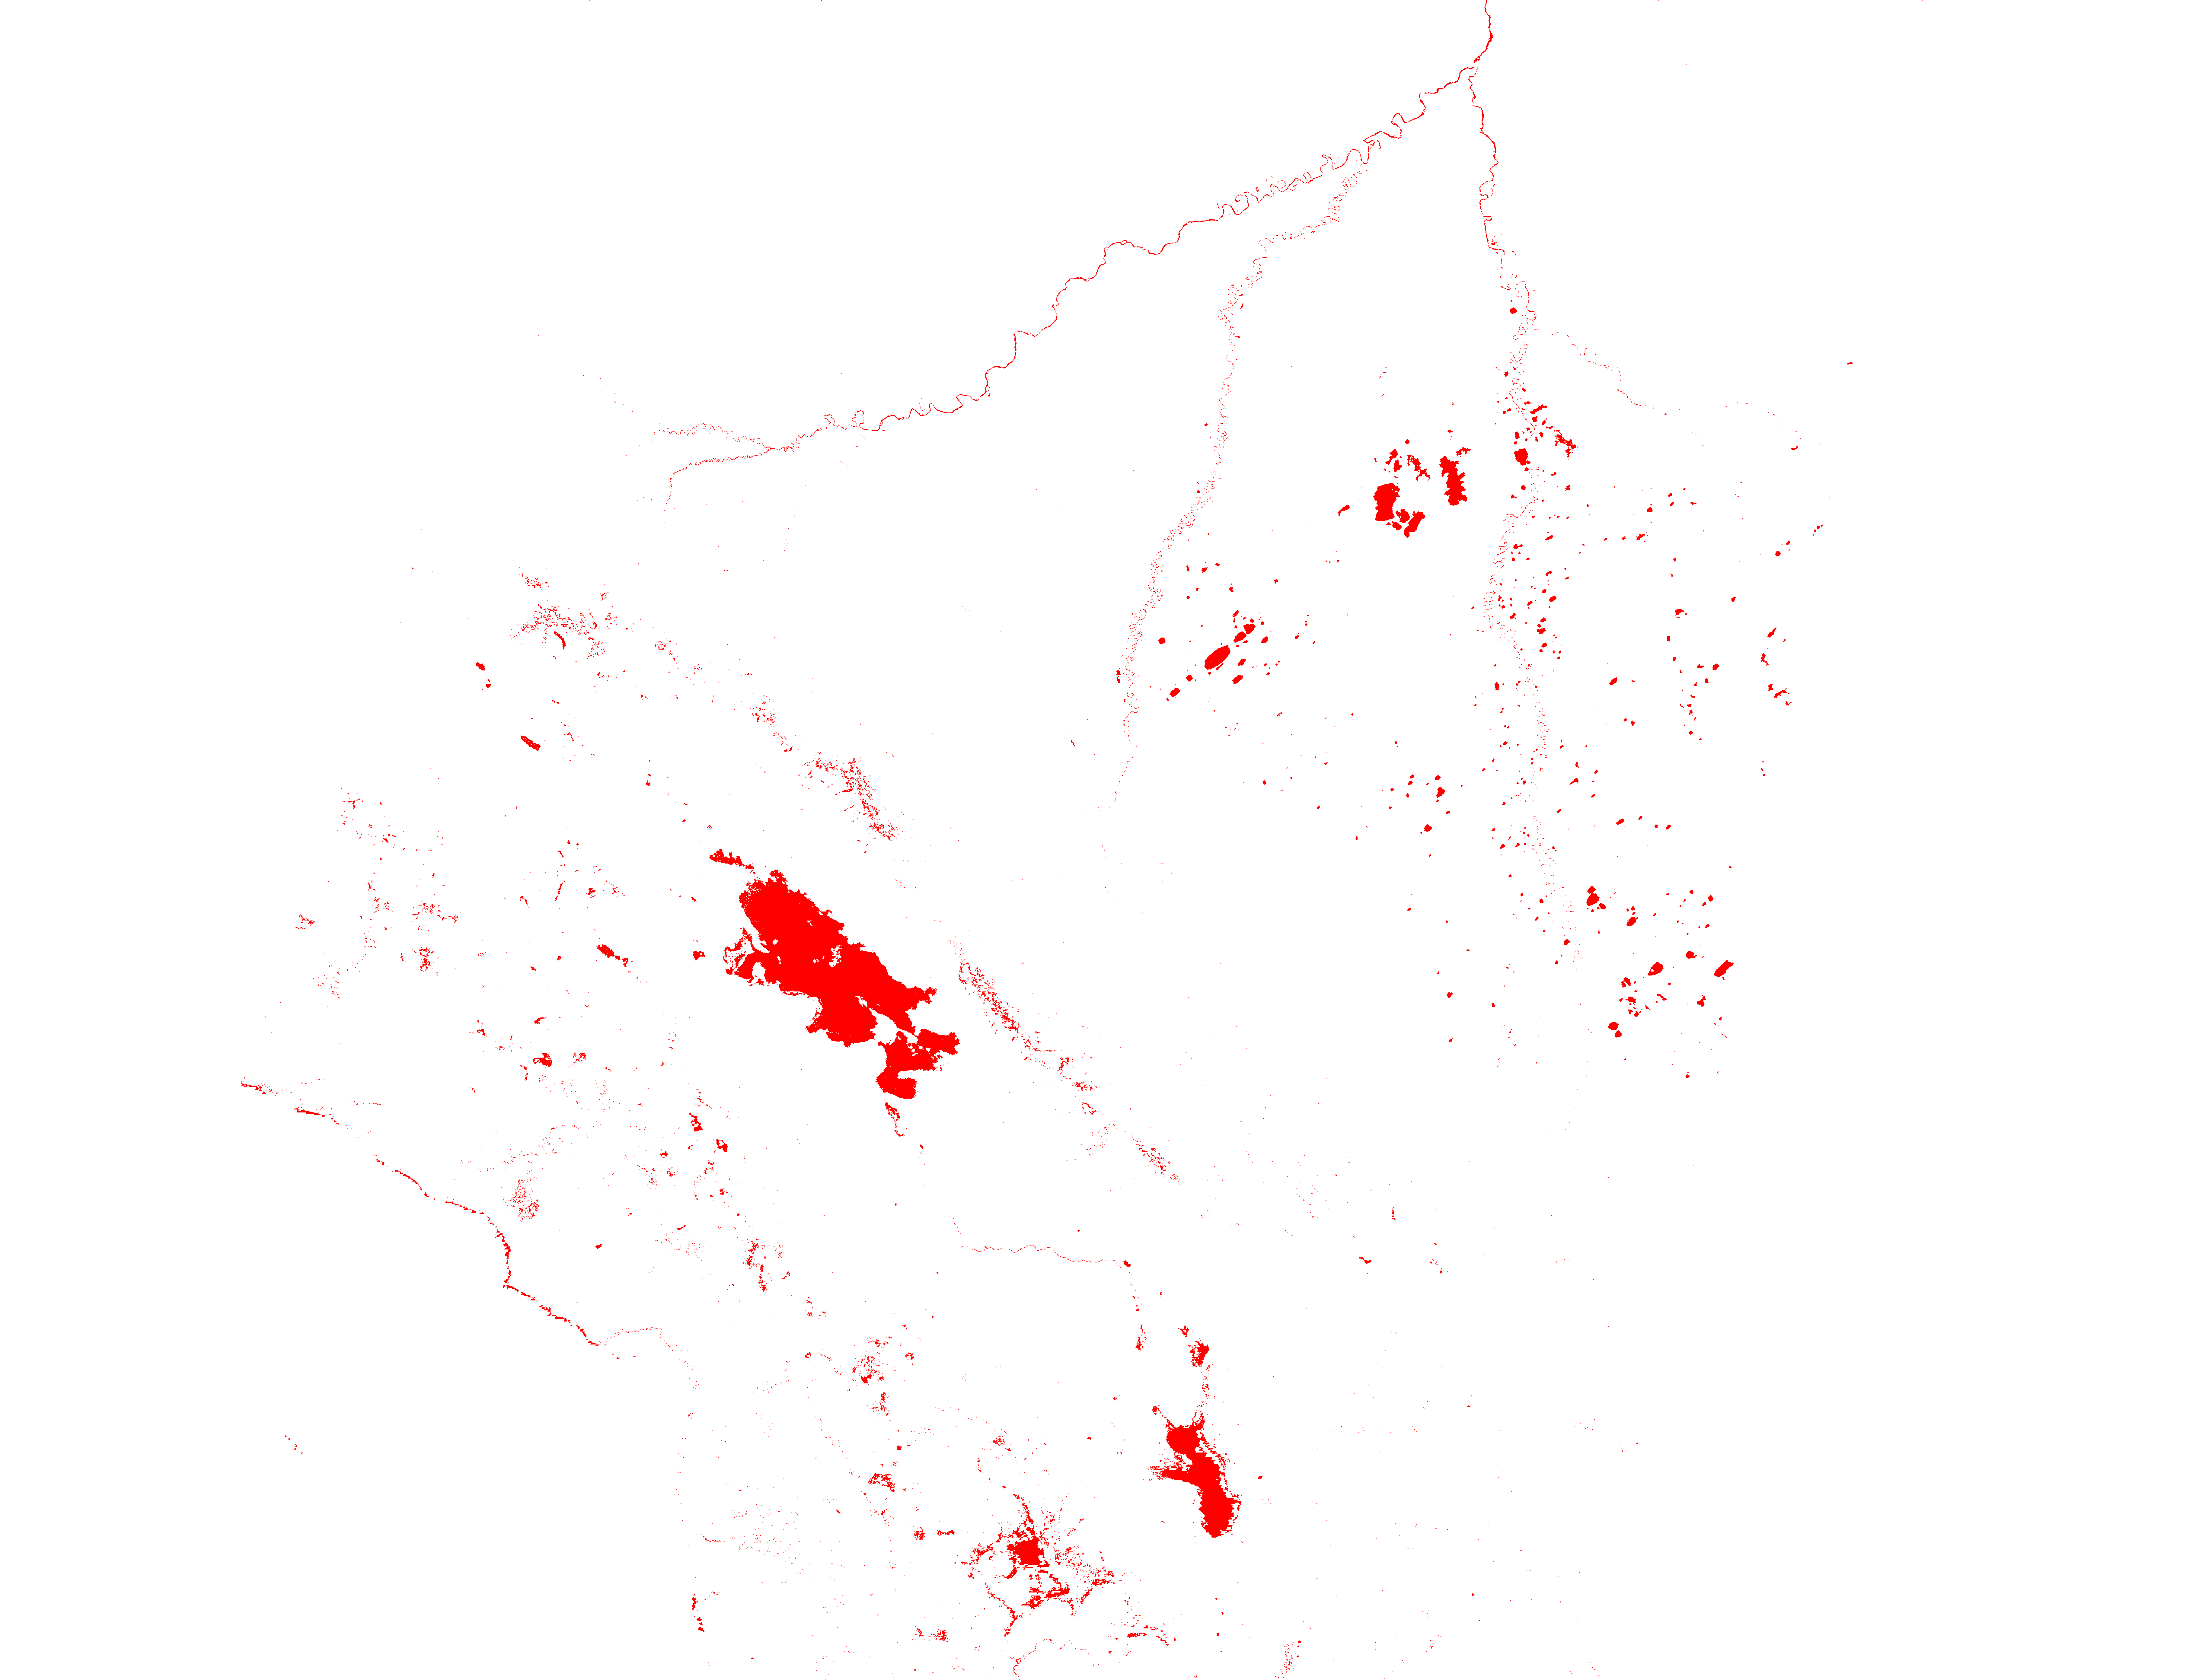
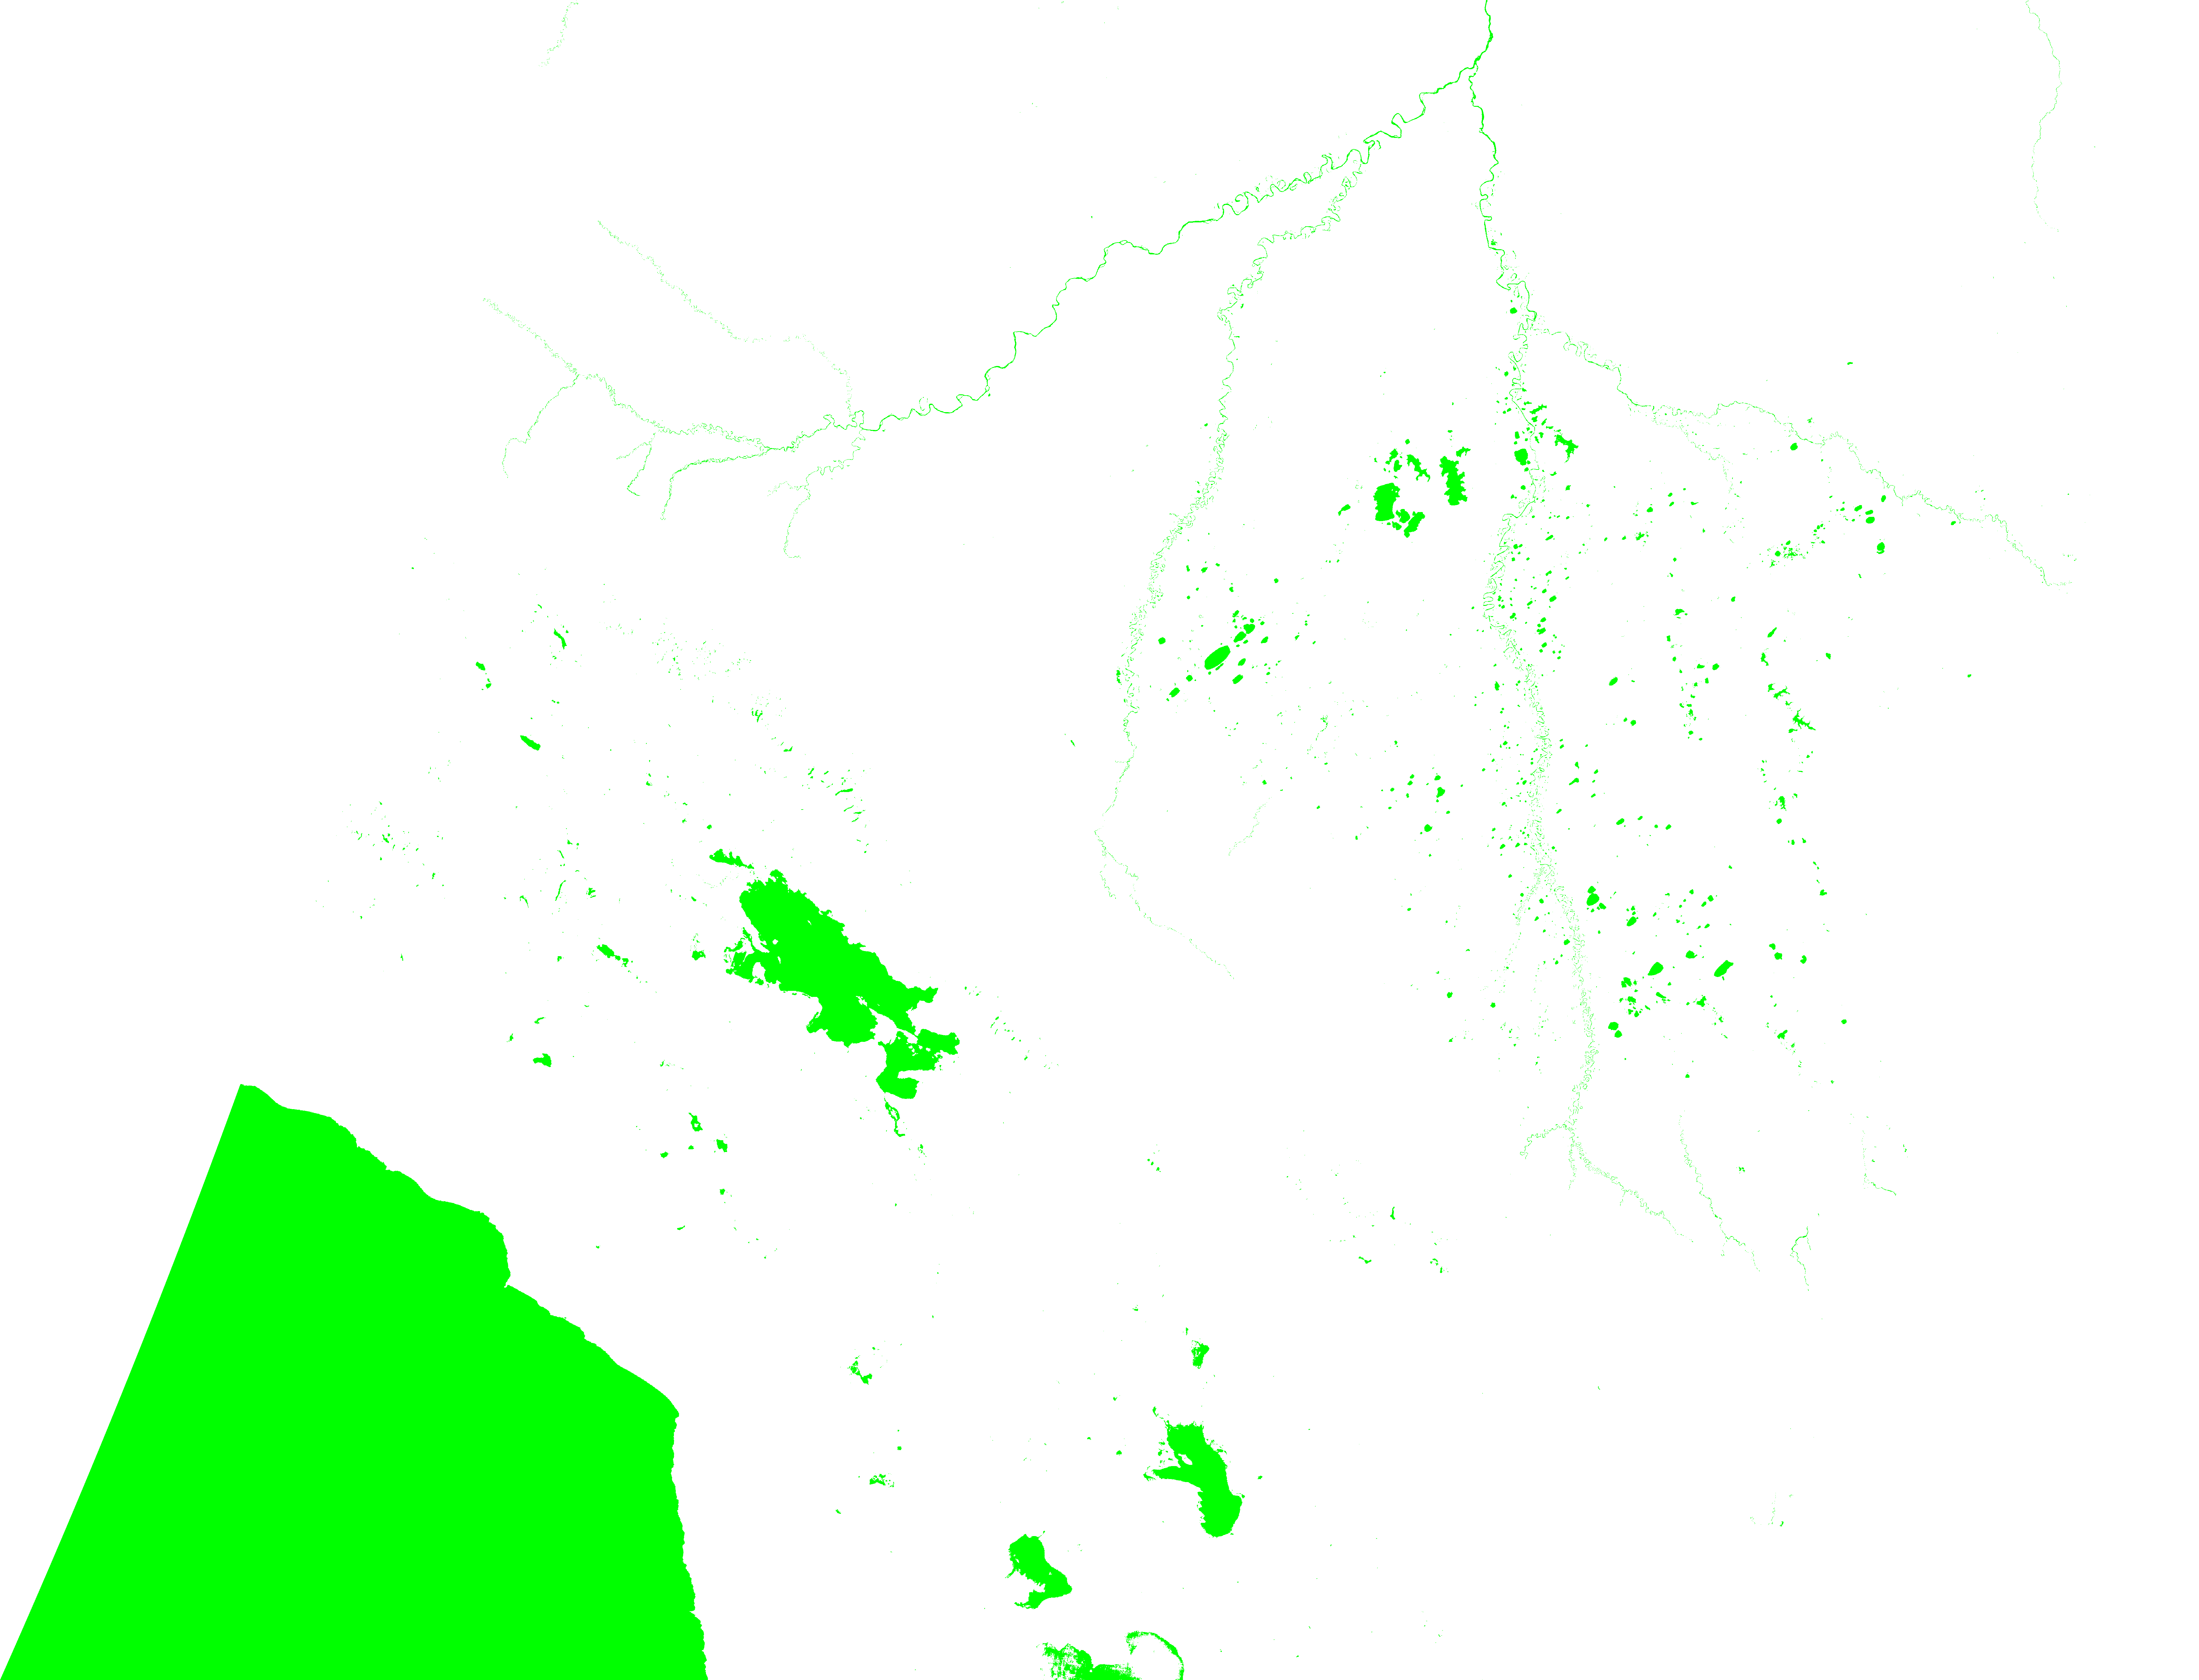

In [95]:

m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())

m